# Input Parameters

In [9]:
#source ISvenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#ISvenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate - to deactivate the virtual environment

#import all the libraries needed
from import_dep import *

# import the class that imports the IS data
from IS_Import import ISdata, ImpedanceData, AgilentIS, SolatronIS, KeithleyIS
from IS_Functions import IS_plot, IS_plot_fit, run_to_dict, update_plot_string, extract_single_dc
from IS_Circuit_Fitting import *
from IS_Debye_Fitting import *


# import custom plot style and colorbar functions
from plot_style import set_plot_style, add_slide

# Define the path to the root directory containing the IS Data 
root_IS_Agilent = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Groningen'
root_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis'

# Define the path to the output directory to save the data
output_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis/Output/'
root_IS_Keithley = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Keithley/Teddy Impedance 1'

# Export settings
fig_format = 'svg' # format of the figure to be saved
plot_transparency = True # set to True to export plots with transparency
export_data = False # set to True to export the data to figures and a powerpoint presentation and save to path_out
powerpoint_string = 'test' # string added to end of powerpoint filename
fig_list = [] # Create a list to flexibly store tuples with the (figure, filename, title) for later exporting


# Custom Scence style settings for figures which returns a figure size to pass to plotting functions if needed
fig_size = set_plot_style(export_data = export_data, use_tex=True)
#plt.style.use(['science', 'grid', 'nature'])




# Capacitance Approximations

In [10]:
e = scipy.constants.epsilon_0  # epsilon_0 constant in F/m (Farads per meter)
C_calc_siox = (e*4*(20e-6)**2)/(25e-9)
print("C_siox", C_calc_siox)
pad_area = (40000+1719.0-12.5)*1e-12
C_calc_pad = (e*7*pad_area)/((110+25)*1e-9) 
print("C_pad", C_calc_pad)

print("formed",(8.854e-12*40*(20e-6)**2)/(1e-9) )



C_siox 5.666680204032001e-13
C_pad 1.9147705850766482e-11
formed 1.4166400000000001e-10


# Import All Data
- This stores a class object which contains the data in "measurements"
- "measurements" is a dictionary with a key: and a ISdata object containing impedance data
- e.g. print(dev_J.measurements.keys())
- measurements is an iter object so "for measurements in dev_J" loops over the ISdata objects in the dict
- measurements also has a __getitem__ meaning that dev_J[0] indexes the first item in the dict (the first ISdata object)

- Here I am using run_to_dict to put all data into a dict where dict[6] contains a list of all the run 6 data

In [11]:
%%capture
#import all solatron data from combined folder
all_data_solatron = SolatronIS(root_IS_solatron, 'All_data')

# loop through the imported data and put all measurements with the same run number into a list
# With each list containing the data for a single run put into a dictionary
solatron = run_to_dict(all_data_solatron)

#import all keithley data from combined folder
all_data_keithley = KeithleyIS(root_IS_Keithley, 'test')

# loop through the imported data and put all measurements with the same run number into a list
# With each list containing the data for a single run put into a dictionary
keithley = run_to_dict(all_data_keithley)

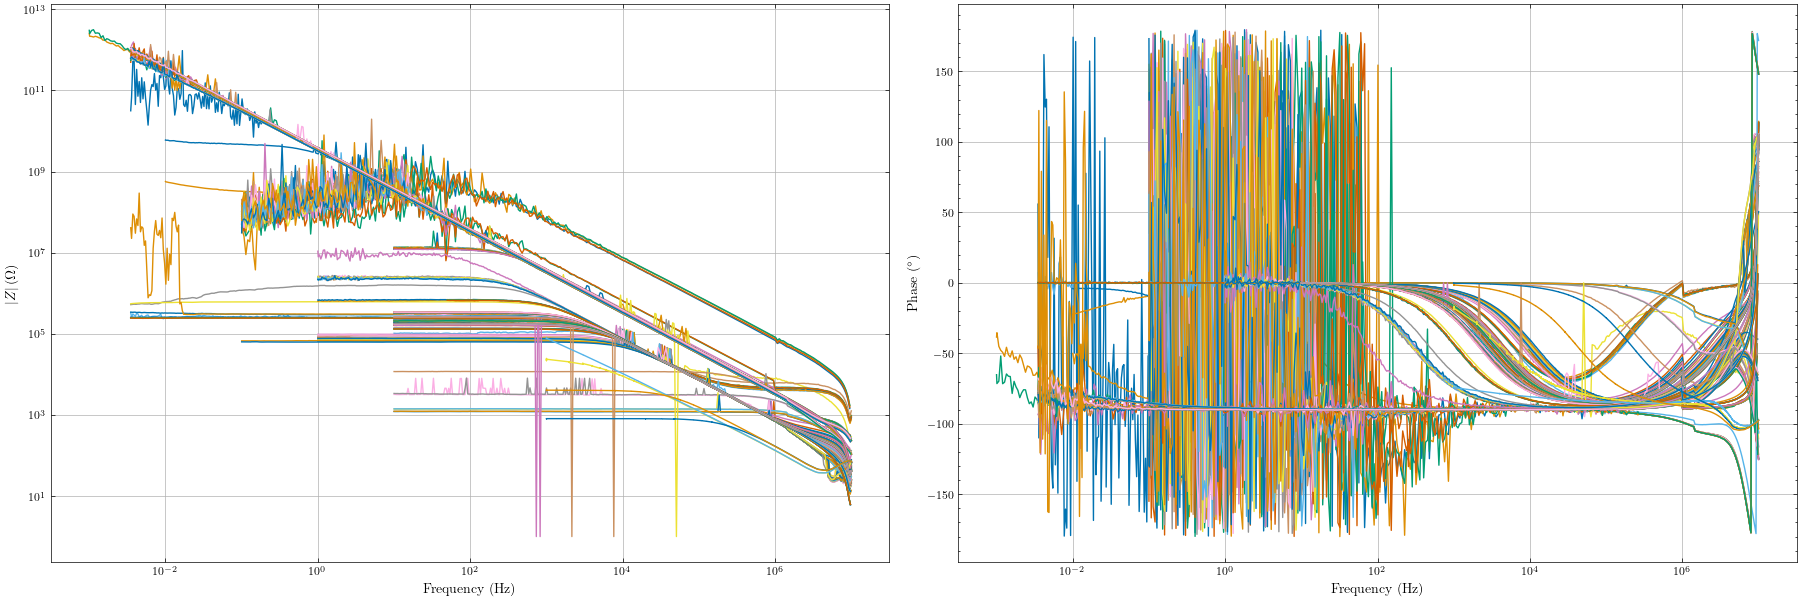

In [15]:
d2 = [keithley[435][0], keithley[439][0], keithley[441][0], keithley[443][0],]
# extract a single DC level from the data

# Filter and plot all solatron data with V_dc ~ 0, average |Z| > 1e3, and state is ambient
filtered_data = []
for run in solatron.values():
    for measurement in run:
        # Check DC offset to 2 decimal places
        if hasattr(measurement, 'DC_offset') and round(measurement.DC_offset, 2) == 0:
            # Check Zabsphi exists and average |Z| > 1e3
            if hasattr(measurement, 'Zabsphi') and measurement.Zabsphi is not None:
                avg_zabs = measurement.Zabsphi[:, 1].mean()
                if avg_zabs > 1e3:
                    # Check state is ambient (not vacuum)
                    if hasattr(measurement, 'vac_state') and measurement.vac_state is not None:
                        if 'amb' in str(measurement.vac_state ).lower():
                            filtered_data.append(measurement)

for dat in d2:
    filtered_data.append(dat)

# Wrap in a list for IS_plot compatibility
if filtered_data:
    plot_labels = [getattr(m, 'plot_string', f'run={getattr(m, "run_number", "?")}') for m in filtered_data]
    filtered_data = [filtered_data]
    fig, ax = IS_plot(filtered_data, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                      sort_data=False, c_bar=0, fig_size=fig_size, med_filt=1, force_key=False, show_key=False,)
else:
    print('No data matched the filter criteria.')


### DC Offset Causing Instability in Memristive State
- Run 5: DC = -1:0.1:1, 50mV AC, 32MHz, Ambient
- NOTE: this is BEFORE the Au contact issue was realised

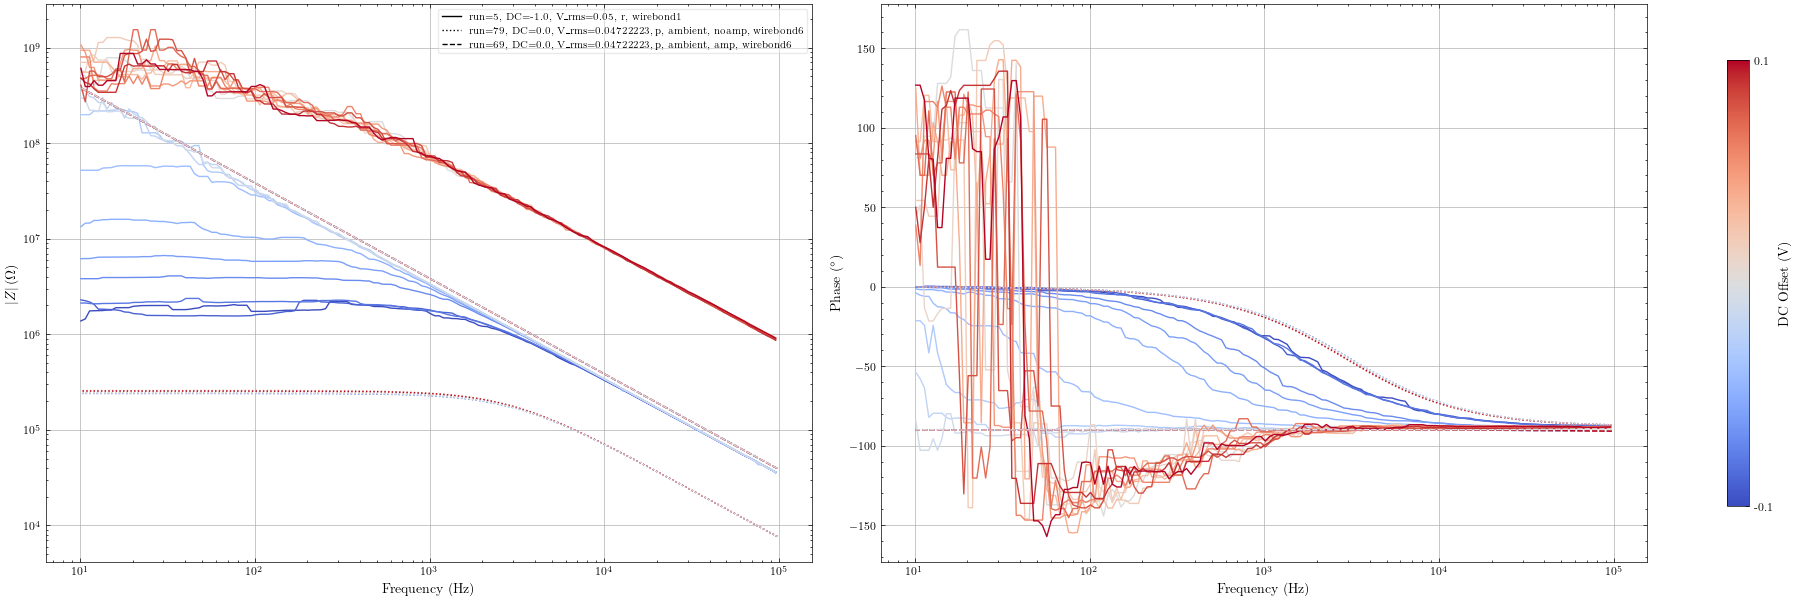

In [4]:
# Select data 
d5 = [solatron[5],solatron[79],solatron[69]]
# extract a single DC level from the data
#d5 = extract_single_dc(d5, DC_val=-0.8)

# Labels
plot_labels = ['wb1, pristine, ambient'] # label for the legend
plot_filename = 'wb1_pristine_Vdc_ambient_instability' # name for exported figure
plot_title = 'Vdc Instability in Pristine Device' # title for powerpoint

# Notes
notes = ['This was before the Au contact issue was realised, likely the cause of the low C state',
         'The device is clearly e-forming during the vDC sweep'] # notes for the powerpoint in text box

# if export true, update the plot string
d5 = update_plot_string(d5, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d5, d_type='Zabsphi', freq_lim=[1e1, 1e5],
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 7, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# Pristine

### Wirebond 3: Ambient vs Vacuum
- run 51: wirebond3, ambient
- run 52: wirebond3, vacuum

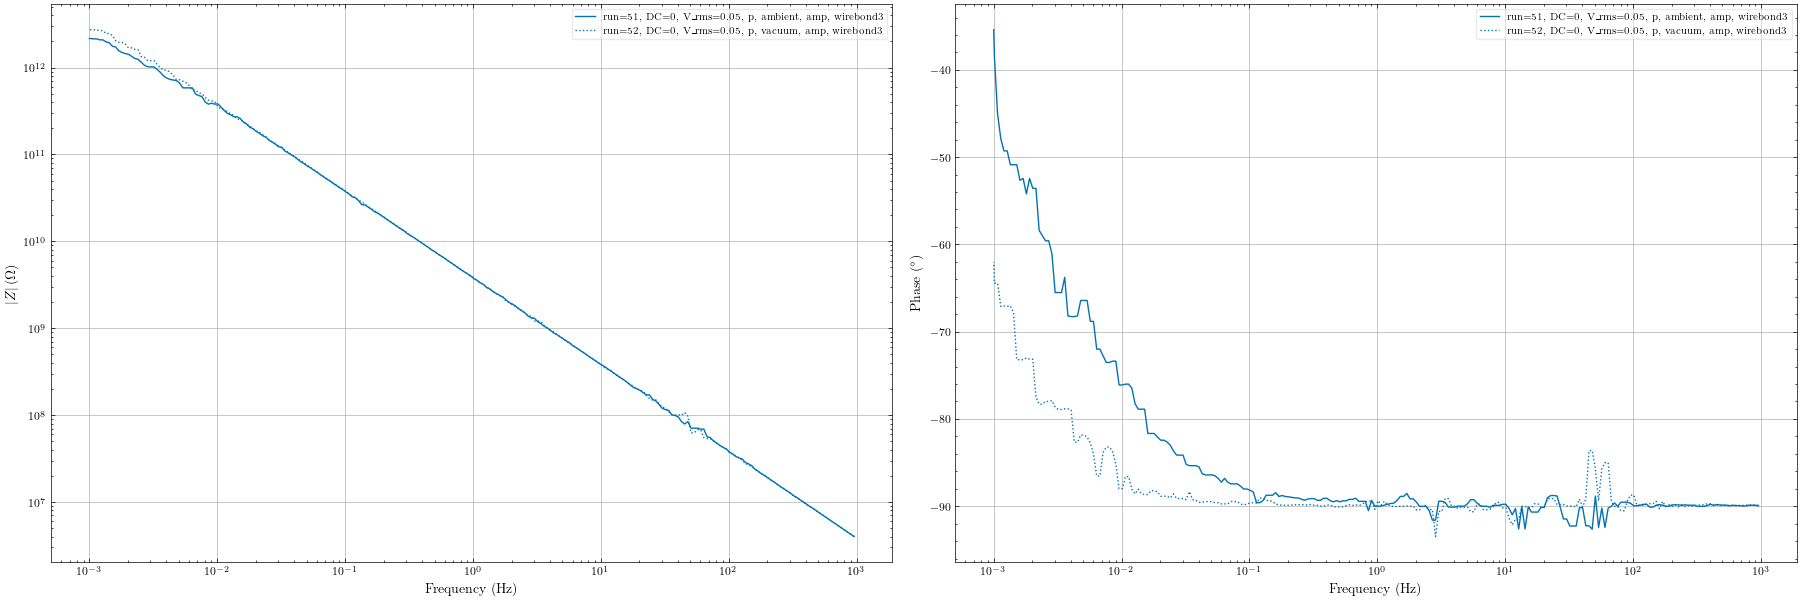

In [5]:
# Select data 
d51 = [solatron[51], solatron[52]]

# Labels
plot_labels = ['wb3, pristine, ambient', 'wb3, pristine, vacuum'] # label for the legend
plot_filename = 'wb3_pristine_ambvac' # name for exported figure
plot_title = 'Ambient vs Vacuum for Pristine Device - WB3' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d51 = update_plot_string(d51, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d51, d_type='Zabsphi', freq_lim=[0, 1e3],
                    sort_data=False, c_bar=0, fig_size=fig_size, med_filt = 3, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### Wirebond 4: Ambient vs Vacuum with V_rms varied
- run 55: wirebond4, ambient
- run 56: wirebond4, vacuum
- run 58: wirebond4, vacuum
- run 59: wirebond4, ambient

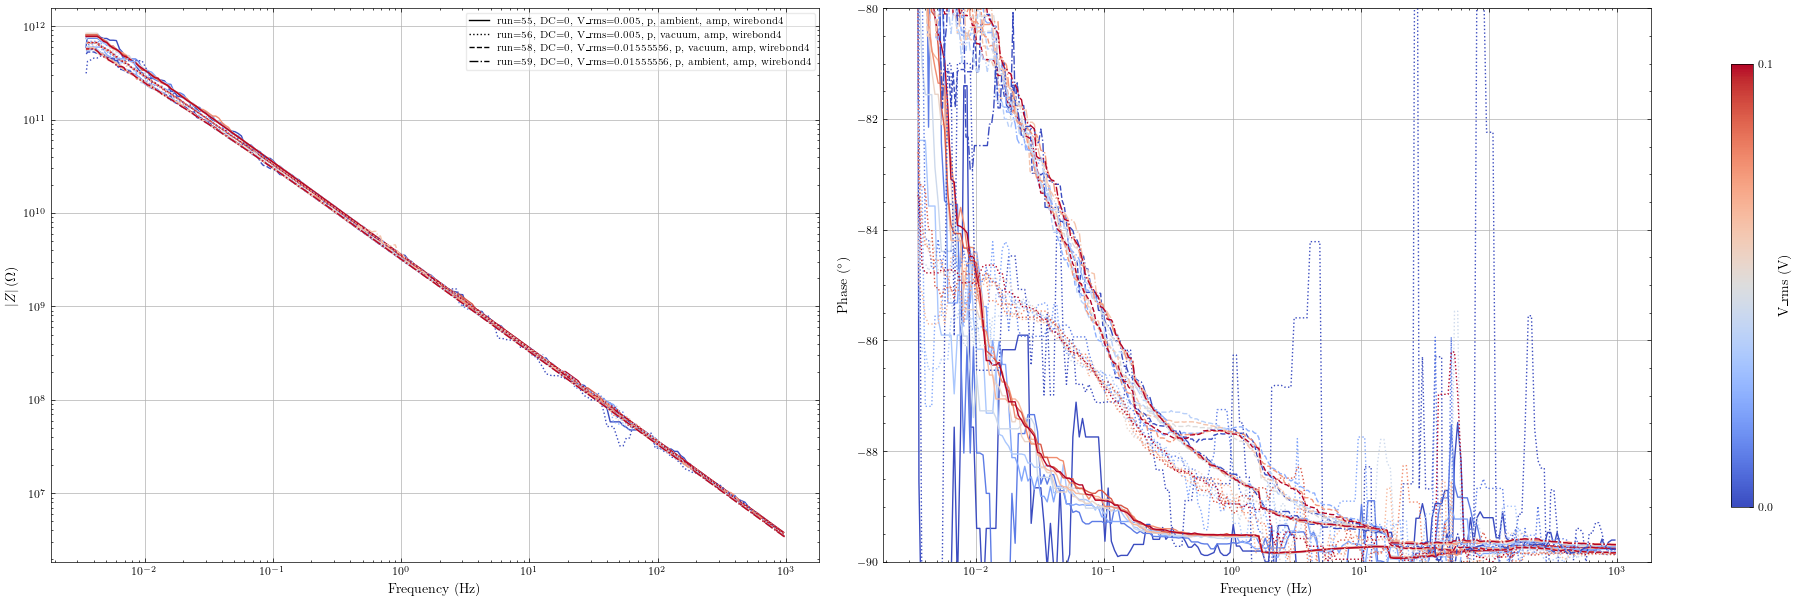

In [6]:
# Select data 
d55 = [solatron[55], solatron[56], solatron[58], solatron[59]]

# Labels
plot_labels = ['wb4, pristine, ambient', 'wb4, pristine, vacuum', 'wb4, pristine, vacuum', 'wb4, pristine, ambient'] # label for the legend
plot_filename = 'wb4_pristine_Vrms_ambvac' # name for exported figure
plot_title = 'Vrms in Ambient vs Vacuum for Pristine Device - WB4' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d55 = update_plot_string(d55, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d55, d_type='Zabsphi', freq_lim=[0, 1e3], y_lim_right=[-90, -80],
                    sort_data=False, c_bar=3, fig_size=fig_size, med_filt = 9, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### Wirebond 4/Wirebond 3: Ambient vs Vacuum with $V_{DC}$
- r60 = wirebond4, vac
- r61 = wirebond4, ambient
- r62 = wirebond3, ambient
- r63 = wirebond3, vac

- Notice that the wirebond 3 has zero phase and infinite resistance
    - This will later prove that **this device won't form**

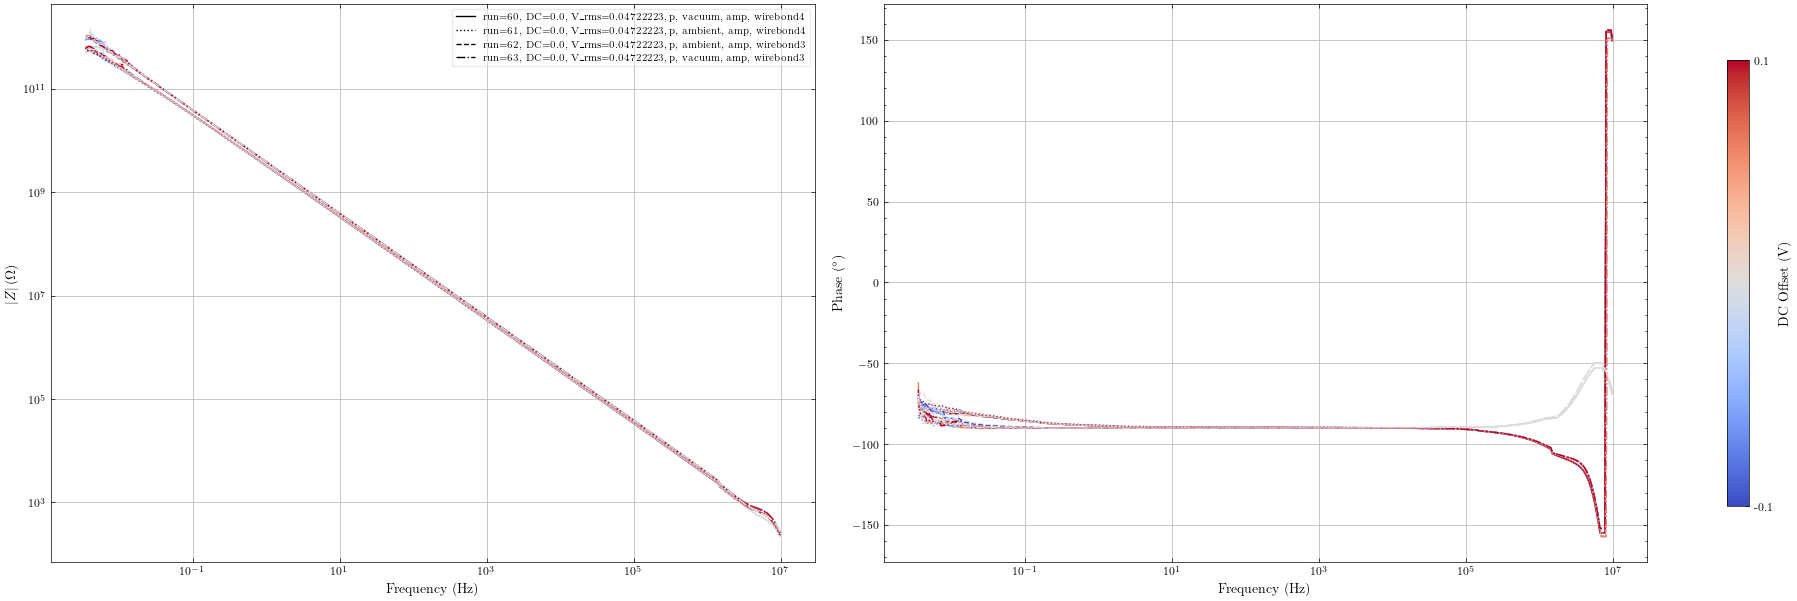

In [7]:
# Select data 
d60 = [solatron[60], solatron[61],solatron[62], solatron[63]]

# Labels
plot_labels = ['wb4, pristine, vacuum', 'wb4, pristine, ambient', 'wb3, pristine, ambient', 'wb3, pristine, vacuum'] # label for the legend
plot_filename = 'wb4wb3_pristine_Vdc_ambvac' # name for exported figure
plot_title = 'Vdc in Ambient vs Vacuum for Pristine Devices - wb3wb4' # title for powerpoint

# Notes
notes = ['- Notice that the wirebond 3 has zero phase and infinite resistance',
        'This will later prove that this device wont form'] # notes for the powerpoint in text box

# if export true, update the plot string
d60 = update_plot_string(d60, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d60, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 9, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### On/Off/Pristine - Across Different Runs

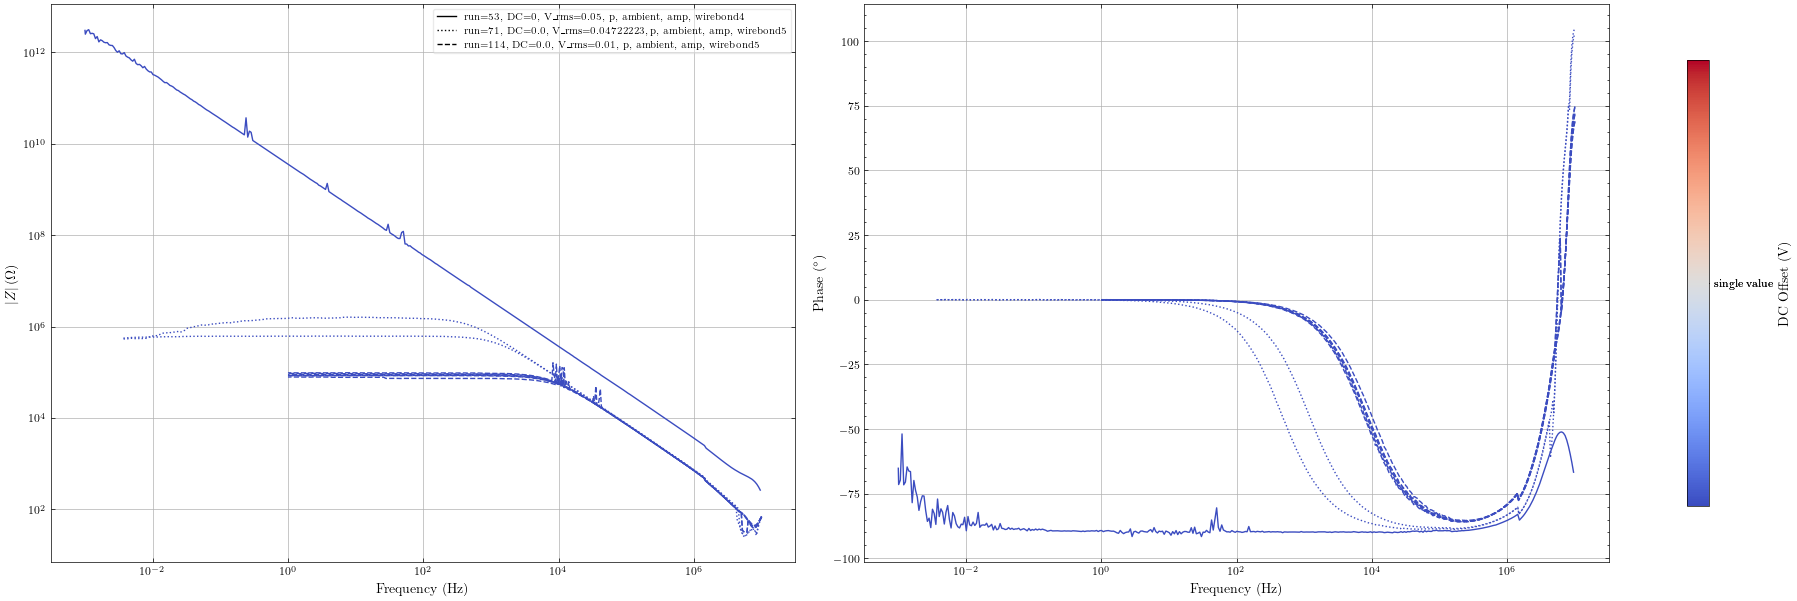

In [8]:
# Select data 
d60 = [solatron[53], solatron[71], solatron[114]]

d60 = extract_single_dc(d60, DC_val=0)
# Labels
plot_labels = ['wb4, pristine, ambient', ''] # label for the legend
plot_filename = 'wb4wb3_pristine_Vdc_ambvac' # name for exported figure
plot_title = 'Vdc in Ambient vs Vacuum for Pristine Devices - wb3wb4' # title for powerpoint

# Notes
notes = ['This is problematic as the Vrms is different for run71'] # notes for the powerpoint in text box

# if export true, update the plot string
d60 = update_plot_string(d60, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d60, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 1, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### SAME DEVICE Pristine vs Formed


--- Starting Fit for: run=79, DC=0.0, V_rms=0.04722223, p, ambient, noamp, wirebond6 ---
Using model: RC
Frequency range: (0, 5000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'C_pad', 'R_series']
550 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 8.5771e-01
  DE Best:)
name R_mem1: 2.55e+05
name C_mem1: 2.00e-10
name C_pad: 1.94e-11
name R_series: 2.01e+01

Running LS Refinement...
LS OK!
  LS Final Cost: 4.2955e-01
  Final Fitted Parameters:
    R_mem1: 2.5467e+05
    C_mem1: 1.9969e-10
    C_pad: 2.0000e-11
    R_series: 2.0113e+01


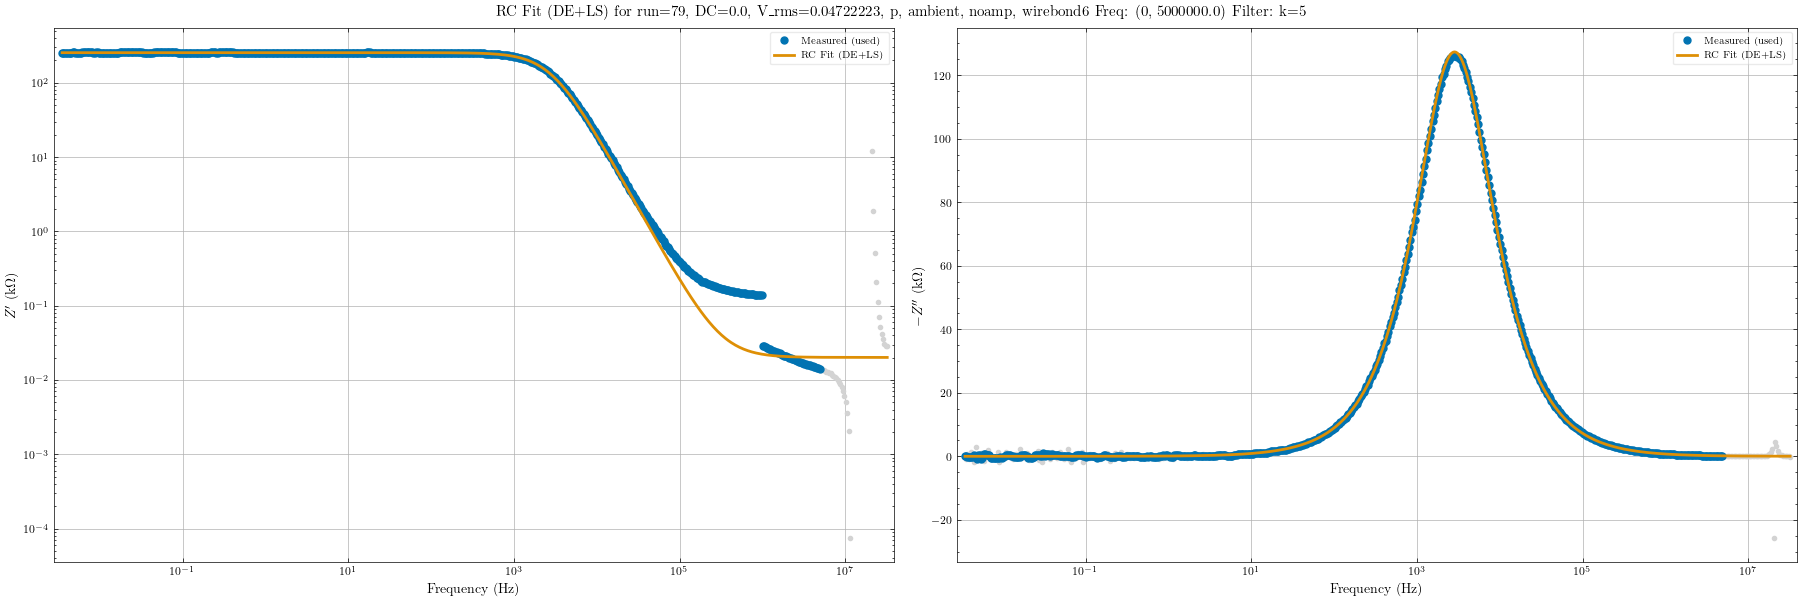


Final Fitted Parameters Dictionary:
{'R_mem1': np.float64(254666.1328125), 'C_mem1': np.float64(1.9969181690335865e-10), 'C_pad': np.float64(2e-11), 'R_series': np.float64(20.112899922439283)}
--- Fit finished for: run=79, DC=0.0, V_rms=0.04722223, p, ambient, noamp, wirebond6 ---


In [9]:
# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2', or 'CPE2'
    'freq_bounds': (0, 5e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    #'fixed_params': {'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': True, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict' :{'R_mem1': (1e1, 1e14), 'C_mem1': (1e-13, 1e-9),'R_mem2': (1e1, 1e14), 'C_mem2': (1e-13, 1e-11),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)},
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 60000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 3000 # Max function evaluations for Least Squares. Increase if refinement terminates early.
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# --- Select Data ---
# Select data 
dfit = [solatron[79][0]] #[solatron[5]]
# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
data_to_fit = dfit[0] # Get the ISdata object


# --- Run Fit ---
fig, ax = fit_impedance_data(data_to_fit, **fit_settings)

# --- Parameter for Plot Exports ---
# Labels
plot_labels = [' r69'] # label for the legend
plot_filename = ' r69' # name for exported figure
plot_title = 'Trial fitting' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
dfit = update_plot_string(dfit, export_data=export_data, plot_labels=plot_labels)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 


/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


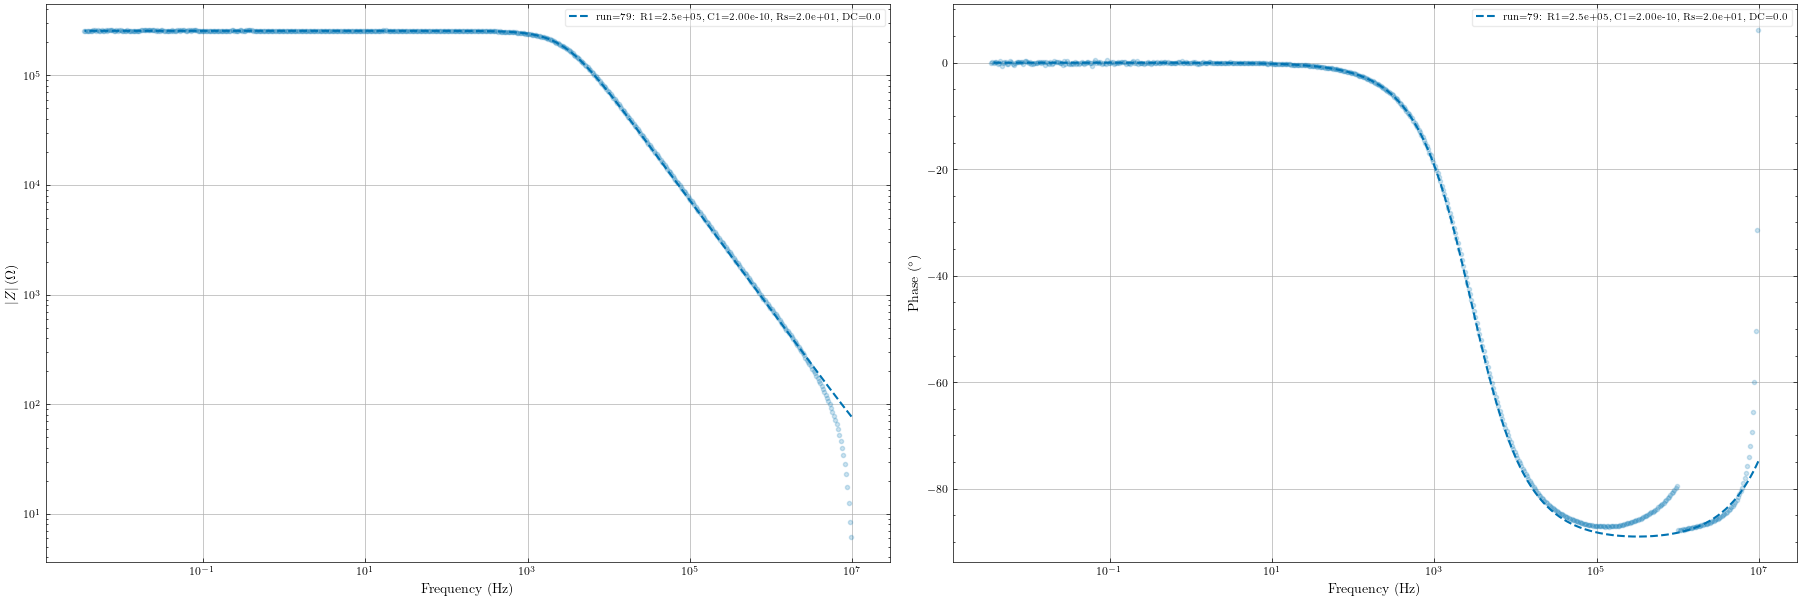

In [10]:
# Select data 
d69 = [solatron[79]] #

# Labels
plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'wb6_pristine_vs_forming' # name for exported figure
plot_title = 'Electroforming vs Pristine' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d69 = update_plot_string(d69, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 1, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

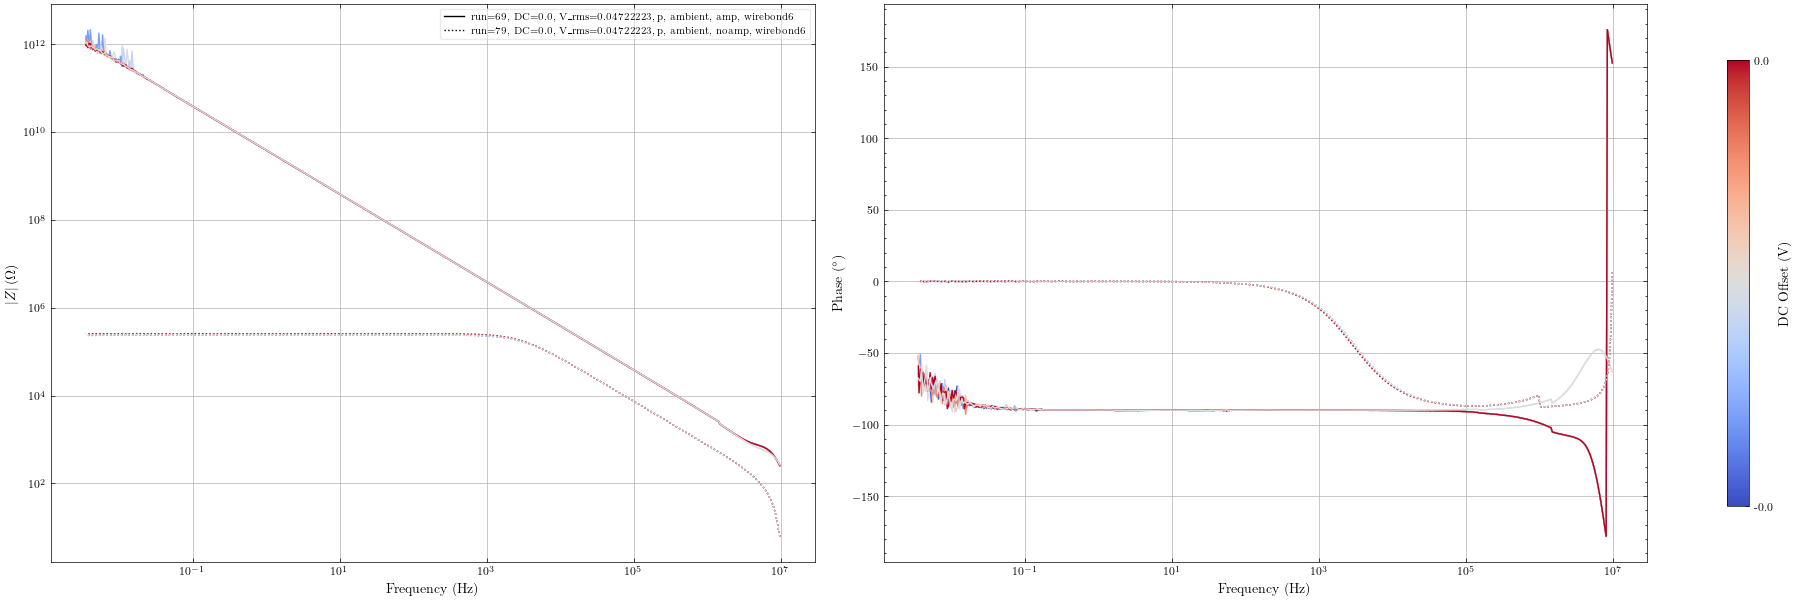

In [11]:
# Select data 
d69 = [solatron[69], solatron[79]] #

# Labels
plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'wb6_pristine_vs_forming' # name for exported figure
plot_title = 'Electroforming vs Pristine' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d69 = update_plot_string(d69, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d69, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 1, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### Live Switching: Ambient vs Vacuum with Looped $V_{DC}$ sweep -> Gives Many Resistance States with DC=0

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


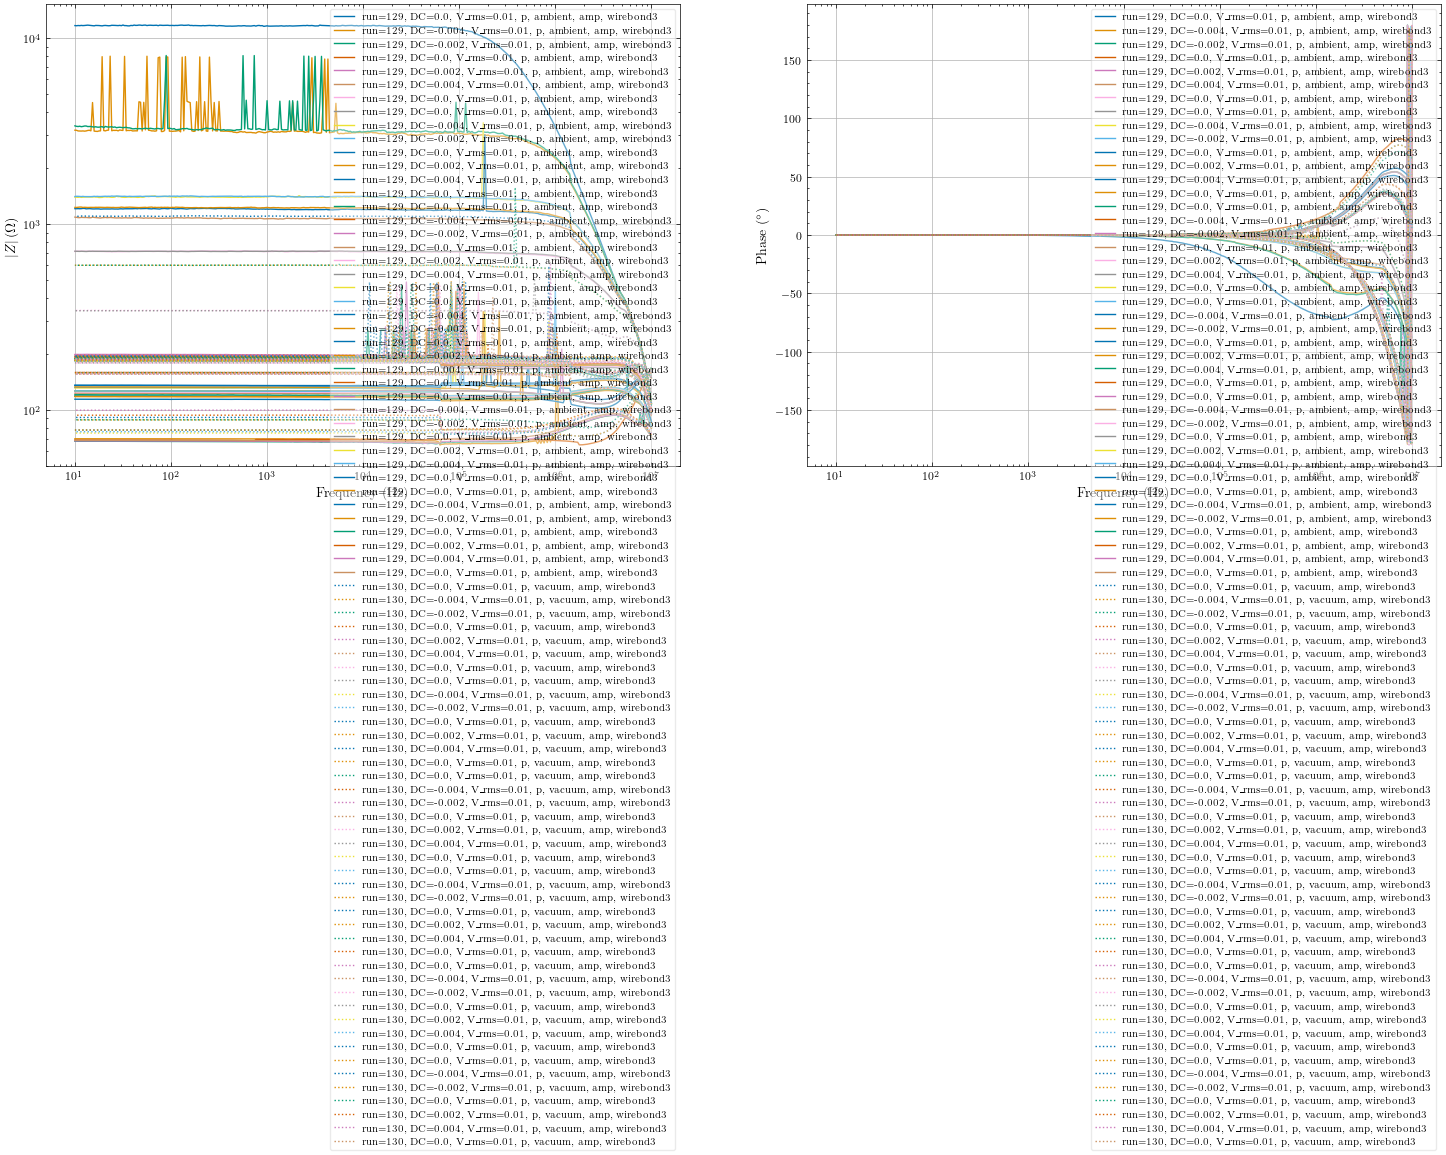

In [12]:
# Select data 
d = [solatron[129],solatron[130]] 
# Extract a single DC offset from the data
d = extract_single_dc(d, DC_val=0)

# Labels
plot_labels = ['wb5, formed, vacuum', 'wb5, formed, ambient-failed', 'wb5, formed, ambient'] # label for the legend
plot_filename = 'wb5_liveswitching_ambvsvac' # name for exported figure
plot_title = 'Switching Device with DC Offset in Vacuum and Ambient' # title for powerpoint

# Notes
notes = [''
         ] # notes for the powerpoint in text box

# if export true, update the plot string
d = update_plot_string(d, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=0, fig_size=fig_size, med_filt = 1, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# Ambient vs Vacuum Stable Changes

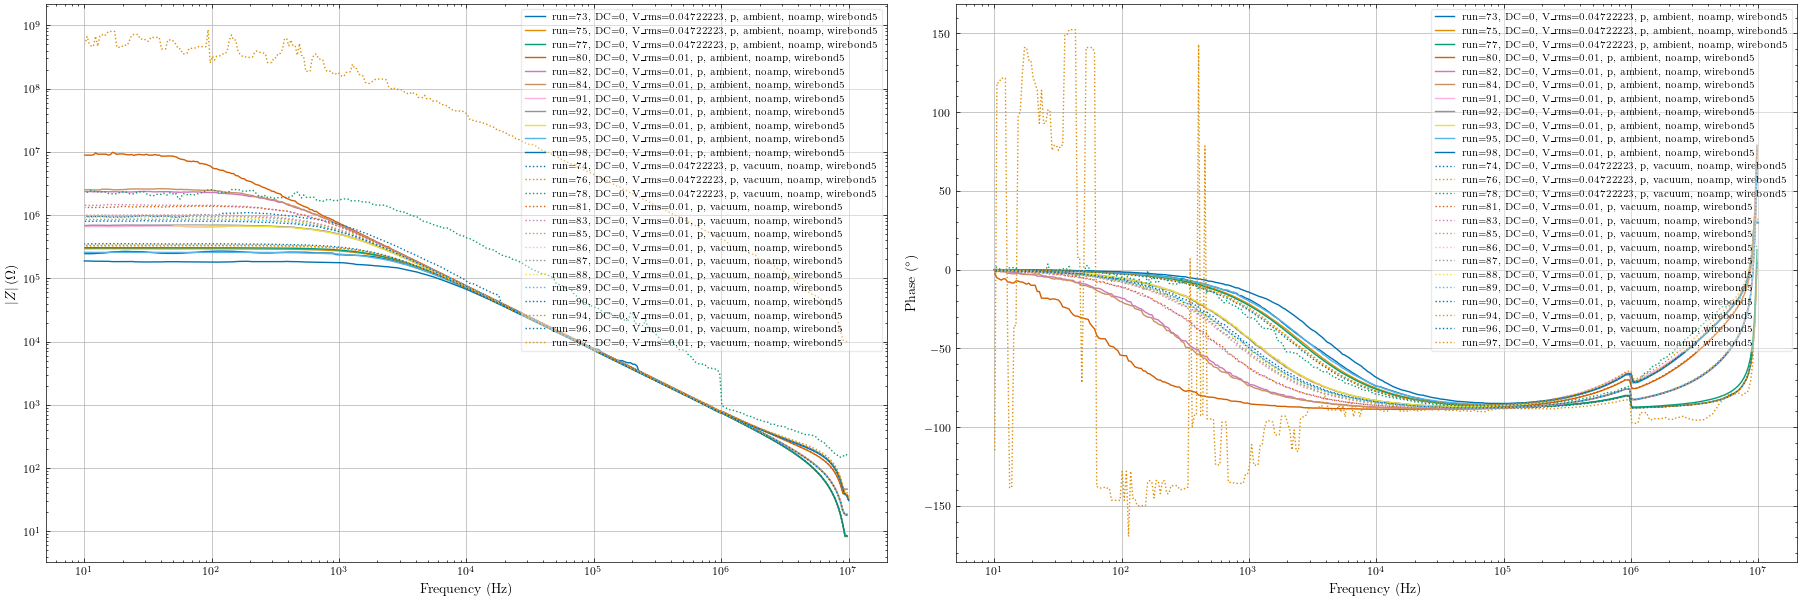

In [13]:
# Select data 
d73 = [ [solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ],  [solatron[74][0], solatron[76][0],solatron[78][0], solatron[81][0], solatron[83][0], solatron[85][0], solatron[86][0], solatron[87][0], solatron[88][0], solatron[89][0], solatron[90][0], solatron[94][0], solatron[96][0], solatron[97][0]] ] #

# Labels
plot_labels = ['wb5, formed, ambient'] # label for the legend
plot_filename = 'wb5_liveswitching' # name for exported figure
plot_title = 'Switching Device with DC Offset' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d73 = update_plot_string(d73, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d73, d_type='Zabsphi', freq_lim=[1e1, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=0, fig_size=fig_size, med_filt = 5, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

In [ ]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': True, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': { 'C_mem1': (1e-13, 1e-9),'R_mem2': (1e1, 1e14), 'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000 # Max function evaluations for Least Squares. Increase if refinement terminates early.
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# --- Select Data ---
# Select data 
data_to_fit  = [ solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0], solatron[74][0], solatron[76][0],solatron[78][0], solatron[81][0], solatron[83][0], solatron[85][0], solatron[86][0], solatron[87][0], solatron[88][0], solatron[89][0], solatron[90][0], solatron[94][0], solatron[96][0], solatron[97][0] ] #
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)

# for dat in data_to_fit:
#     # --- Run Fit ---
#     fig, ax = fit_impedance_data(dat, **fit_settings)




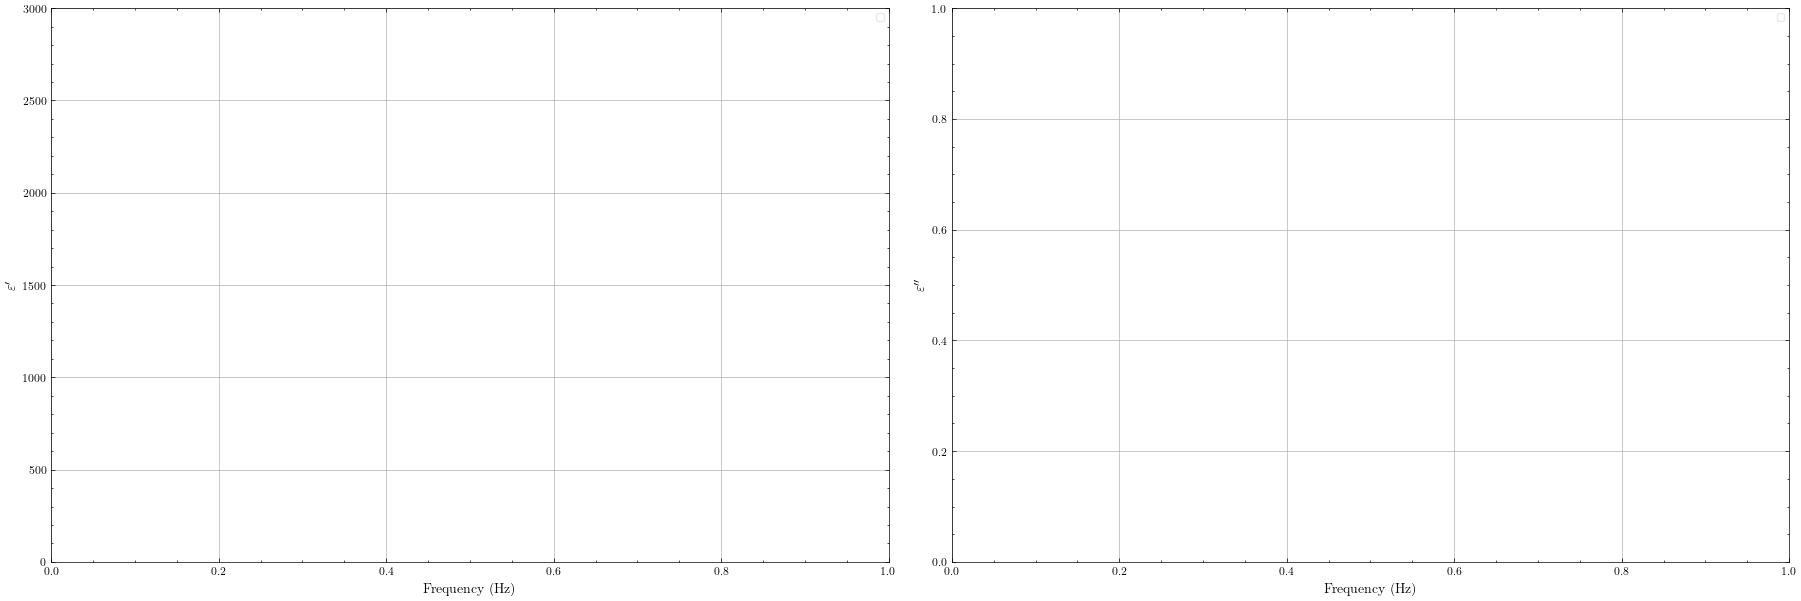

In [15]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Select data 
d69 = [solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# Labels
plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'wb6_pristine_vs_forming' # name for exported figure
plot_title = 'Electroforming vs Pristine' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d69 = update_plot_string(d69, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='permittivity', freq_lim=[1e-3, 1e7], y_lim_left=[0,3000],
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

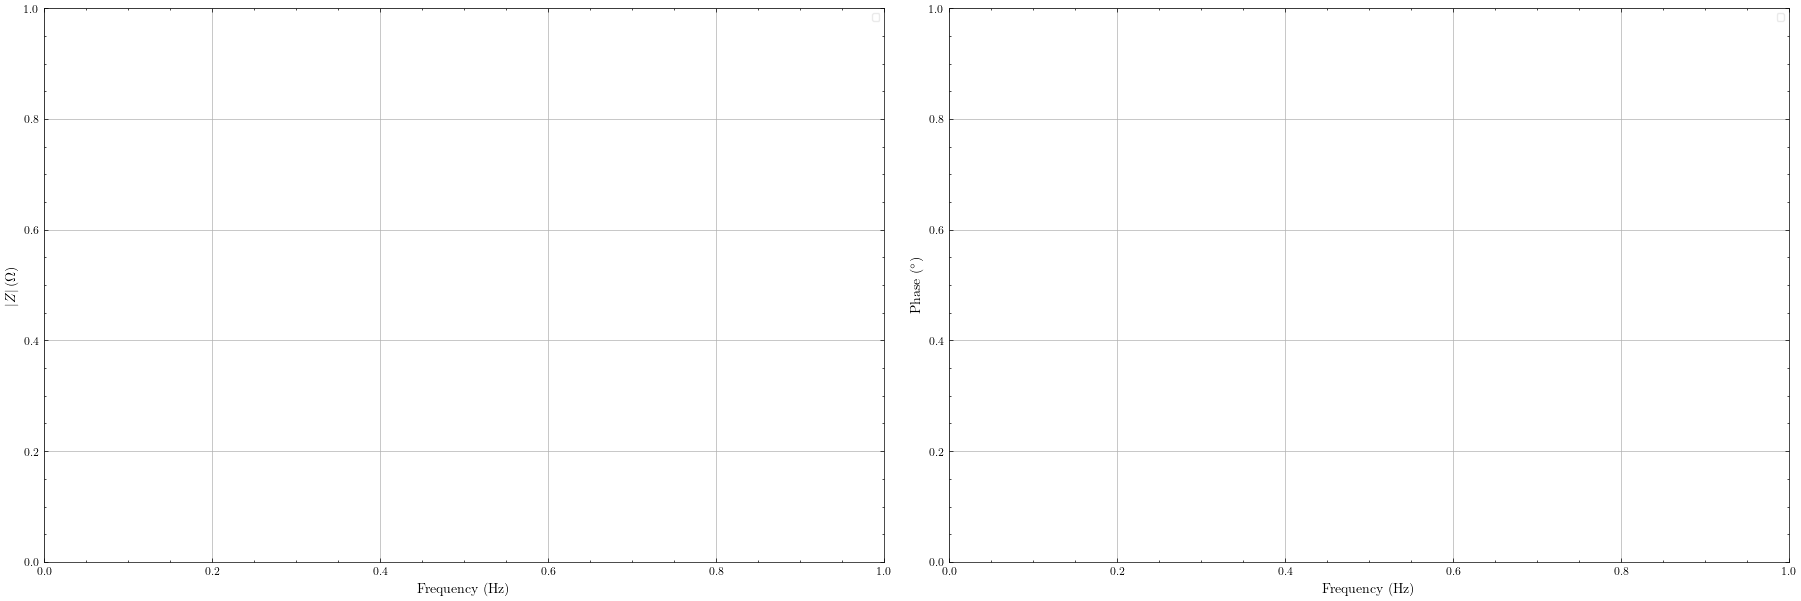

In [16]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Select data 
d69 = [solatron[74][0], solatron[76][0],solatron[78][0], solatron[81][0], solatron[83][0], solatron[85][0], solatron[86][0], solatron[87][0], solatron[88][0], solatron[89][0], solatron[90][0], solatron[94][0], solatron[96][0], solatron[97][0]]
# Labels
plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'wb6_pristine_vs_forming' # name for exported figure
plot_title = 'Electroforming vs Pristine' # title for powerpoint

# Notes
notes = [''] # notes for the powerpoint in text box

# if export true, update the plot string
d69 = update_plot_string(d69, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e1, 1e5], y_lim_right=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 1, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 



# Debye Fitting

In [17]:
# --- Example Call ---

# --- Define C_0 (Geometric Capacitance) ---
# You MUST calculate this based on your sample geometry
# Example: Area = (1e-3)**2 * np.pi, thickness = 0.5e-3 # Meters
# C_0 = epsilon_0 * Area / thickness
# Replace with your actual value:
sample_C_0 = epsilon_0 * (20e-6)**2 / (25e-9) # Example: 200um x 200um area, 25nm thickness

# --- Choose Data ---
try:
    data_to_fit = solatron[79][0]
    data_available = True
    if data_to_fit.Zrealimag is None: raise ValueError("Missing Zrealimag")
except Exception as e:
     print(f"Error loading data: {e}")
     data_available = False

if data_available:
    # --- Define Settings for Dielectric Fit ---
    num_relax = 3 # Choose 1, 2, or 3

    # Define bounds ONLY for parameters used in the 2-relaxation model
    specific_de_bounds = {
       'eps_inf': (1.0, 50.0),
       'delta_eps1': (1e-1, 1e4), 'tau1': (1e-7, 1e-1), # Slower process
       'delta_eps2': (1e-1, 1e3), 'tau2': (1e-10, 1e-5), # Faster process
       'sigma_dc': (0, 1e-3)
    }
    specific_ls_bounds = {
       'eps_inf': (1.0, np.inf),
       'delta_eps1': (0, np.inf), 'tau1': (1e-12, np.inf),
       'delta_eps2': (0, np.inf), 'tau2': (1e-13, np.inf),
       'sigma_dc': (0, np.inf)
    }
    # Optional initial guess
    # specific_initial_guess = {
    #    'eps_inf': 5.0, 'delta_eps1': 100, 'tau1': 1e-4,
    #    'delta_eps2': 10, 'tau2': 1e-7, 'sigma_dc': 1e-8
    # }

    # Assemble the settings dictionary
    fit_settings = {
        'n_relaxations': num_relax,
        'C_0': sample_C_0,              # Pass C_0
        'C_pad_to_subtract': C_calc_pad, # Pass C_pad
        'freq_bounds': (1e0, 1e6),      # Example range
        'med_filt': 0,
        'fixed_params': {'eps_inf': 2.2}, #None,           # Example: {'sigma_dc': 0}
        'plot_fit': True,
        'plot_type': 'Zabsphi',
        'fig_size': fig_size,
        'use_de': True,
        'de_bounds_dict': specific_de_bounds,
        'ls_bounds_dict': specific_ls_bounds,
        'initial_guess_dict': None, # specific_initial_guess,
        'de_maxiter': 700,
        'ls_max_nfev': 5000,
        # Optional stricter LS tolerances
        # 'ls_ftol': 1e-12, 'ls_xtol': 1e-12, 'ls_gtol': 1e-12
    }

    # --- Run Fit ---
    print(f"\n*** Running fit with settings: ***\n{fit_settings}\n")
    
    # fig, ax, a , b = fit_impedance_dielectric(data_to_fit, **fit_settings)



*** Running fit with settings: ***
{'n_relaxations': 3, 'C_0': 1.4166700510080003e-13, 'C_pad_to_subtract': 1.9147705850766482e-11, 'freq_bounds': (1.0, 1000000.0), 'med_filt': 0, 'fixed_params': {'eps_inf': 2.2}, 'plot_fit': True, 'plot_type': 'Zabsphi', 'fig_size': [9, 6], 'use_de': True, 'de_bounds_dict': {'eps_inf': (1.0, 50.0), 'delta_eps1': (0.1, 10000.0), 'tau1': (1e-07, 0.1), 'delta_eps2': (0.1, 1000.0), 'tau2': (1e-10, 1e-05), 'sigma_dc': (0, 0.001)}, 'ls_bounds_dict': {'eps_inf': (1.0, inf), 'delta_eps1': (0, inf), 'tau1': (1e-12, inf), 'delta_eps2': (0, inf), 'tau2': (1e-13, inf), 'sigma_dc': (0, inf)}, 'initial_guess_dict': None, 'de_maxiter': 700, 'ls_max_nfev': 5000}



# Live Switching Ambient vs Vacuum Fitted


--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.2264e-01
  DE Best:)
name R_mem1: 1.26e+04
name C_mem1: 1.00e-08
name R_mem2: 4.04e+03
name C_mem2: 2.29e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.1986e-01
  Final Fitted Parameters:
    R_mem1: 1.2559e+04
    C_mem1: 9.9000e-09
    R_mem2: 4.0419e+03
    C_mem2: 2.2904e-10
    C_pad: 1.9148e-11
    R_series: 1.0000e+00


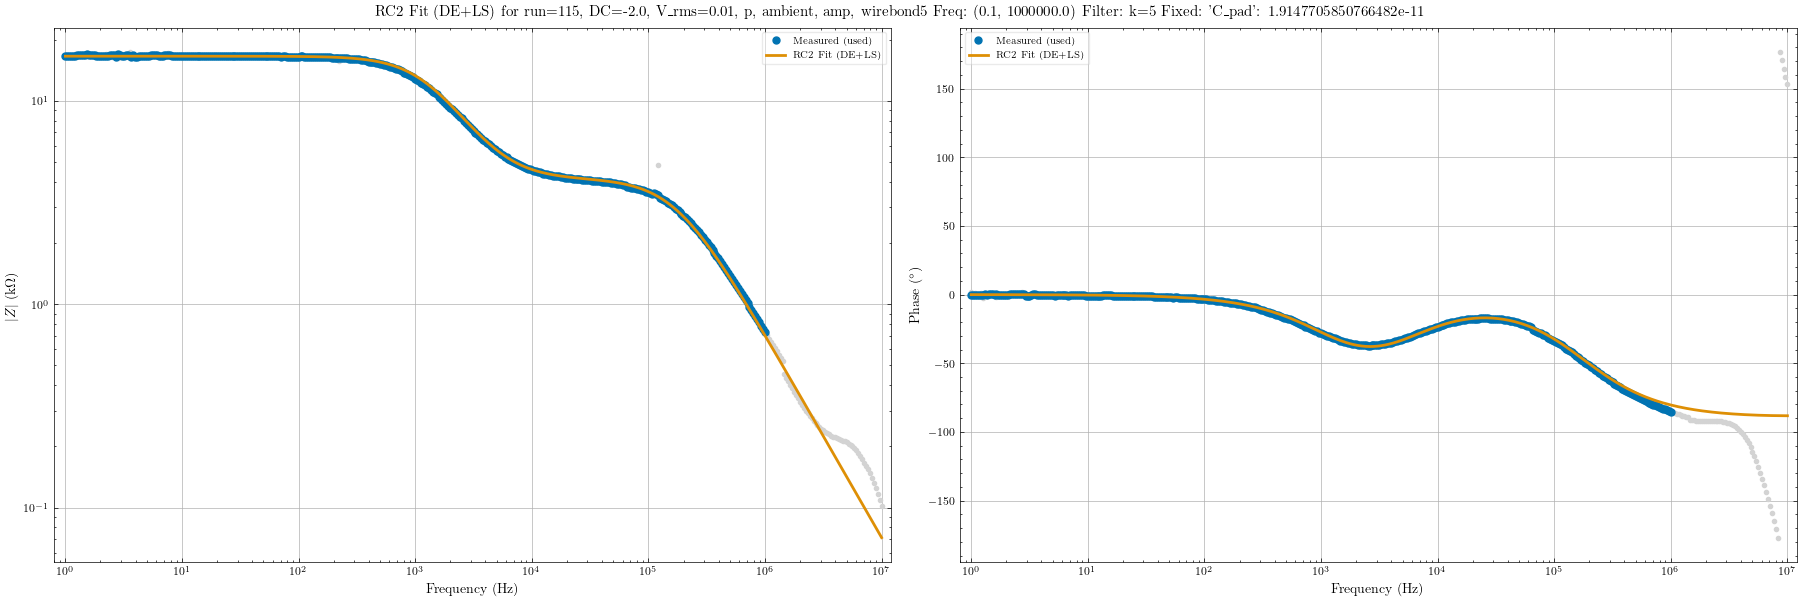


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12559.429347994097), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(4041.913773488546), 'C_mem2': np.float64(2.2903941451409224e-10), 'R_series': np.float64(1.000026018355129)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.9652e-01
  DE Best:)
name R_mem1: 1.28e+04
name C_mem1: 1.00e-08
name R_mem2: 3.92e+03
name C_mem2: 2.29e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.5685e-01
  Final Fitted Parameters:
    R_mem1: 1.2850e+04
    C_mem1: 9.9000e-09
    R_mem2: 3.

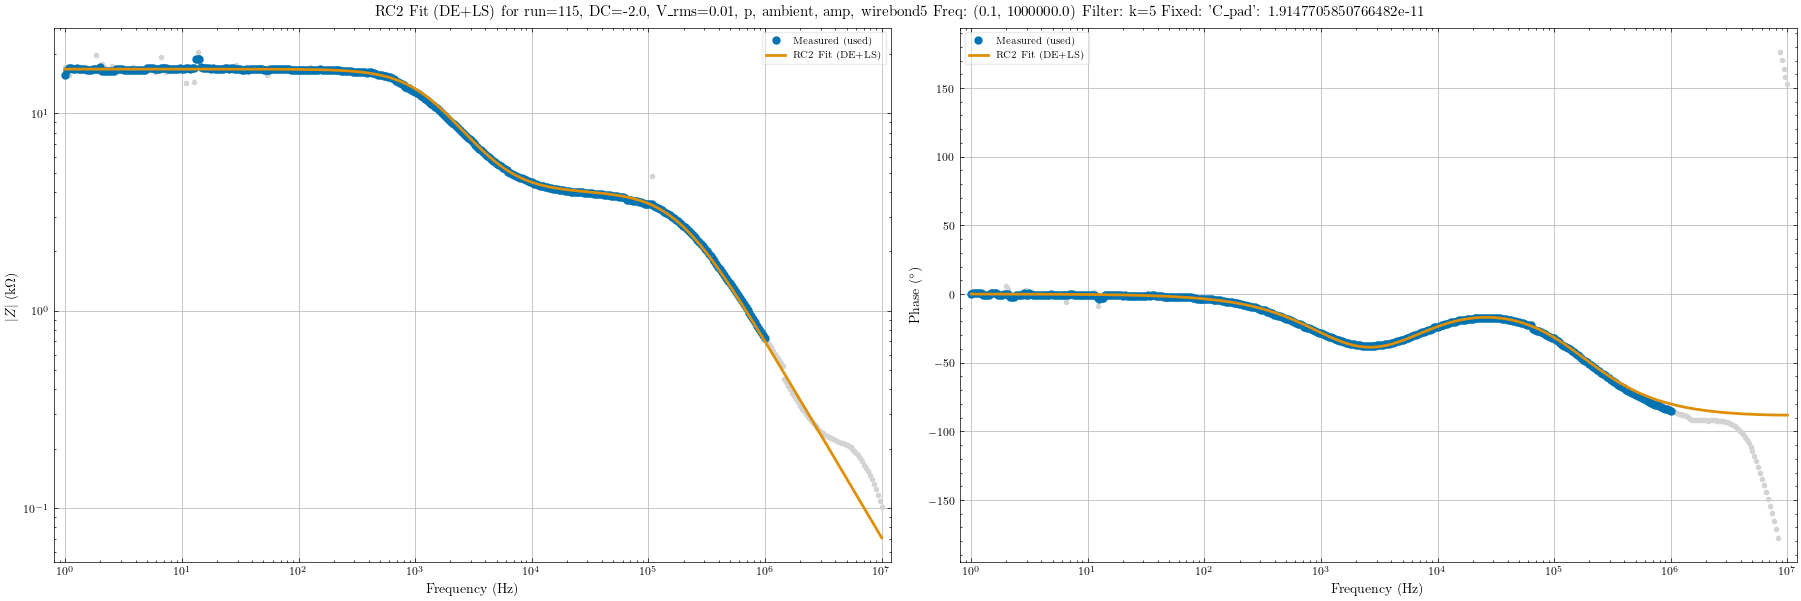


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12849.616120352992), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3916.3388604738434), 'C_mem2': np.float64(2.2932869377180915e-10), 'R_series': np.float64(1.0000413495536122)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.1103e-01
  DE Best:)
name R_mem1: 1.36e+04
name C_mem1: 1.00e-08
name R_mem2: 3.87e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.6295e-01
  Final Fitted Parameters:
    R_mem1: 1.3584e+04
    C_mem1: 9.9000e-09
    R_mem2: 

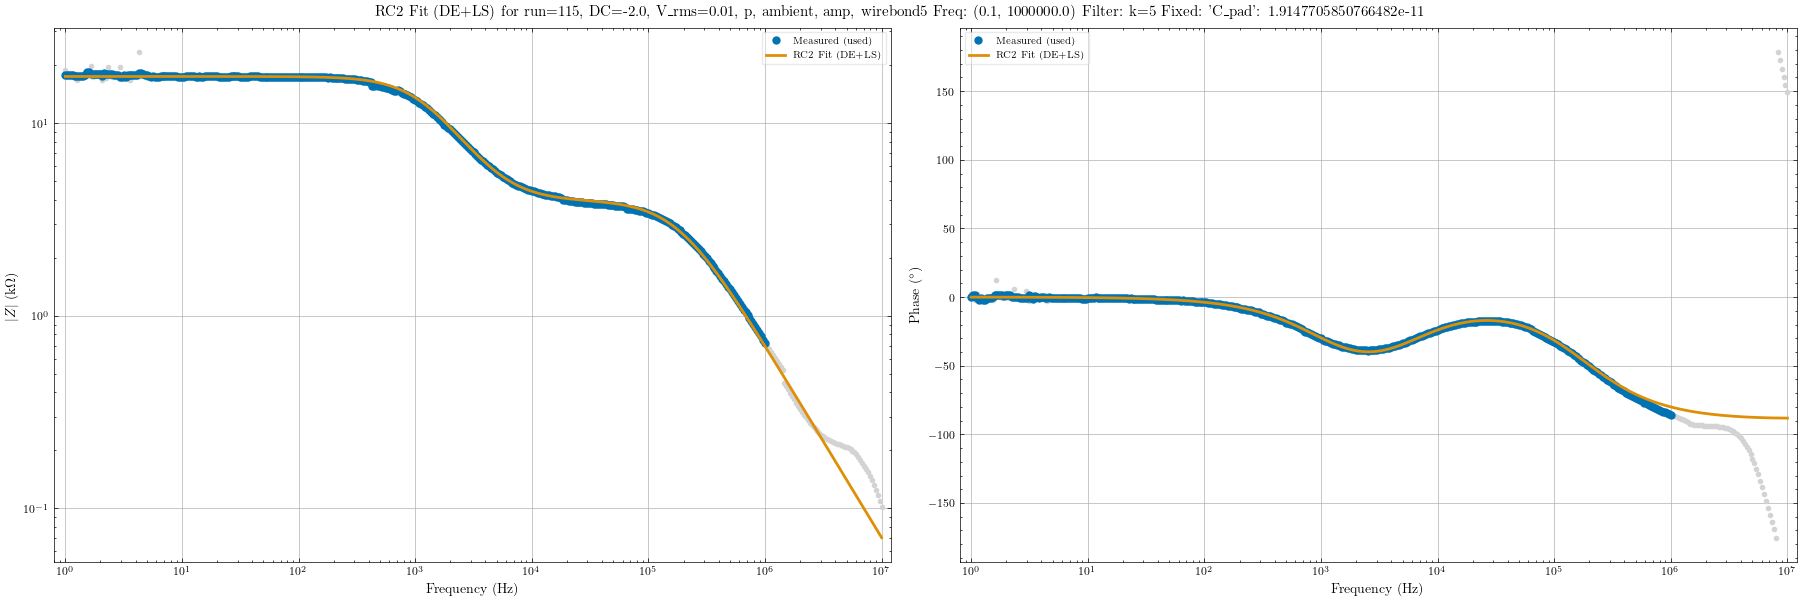


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13583.999712907244), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3867.364443727522), 'C_mem2': np.float64(2.3085697076357044e-10), 'R_series': np.float64(1.0001274797268707)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 5.6611e-01
  DE Best:)
name R_mem1: 1.34e+04
name C_mem1: 1.00e-08
name R_mem2: 3.93e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.9174e-01
  Final Fitted Parameters:
    R_mem1: 1.3446e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

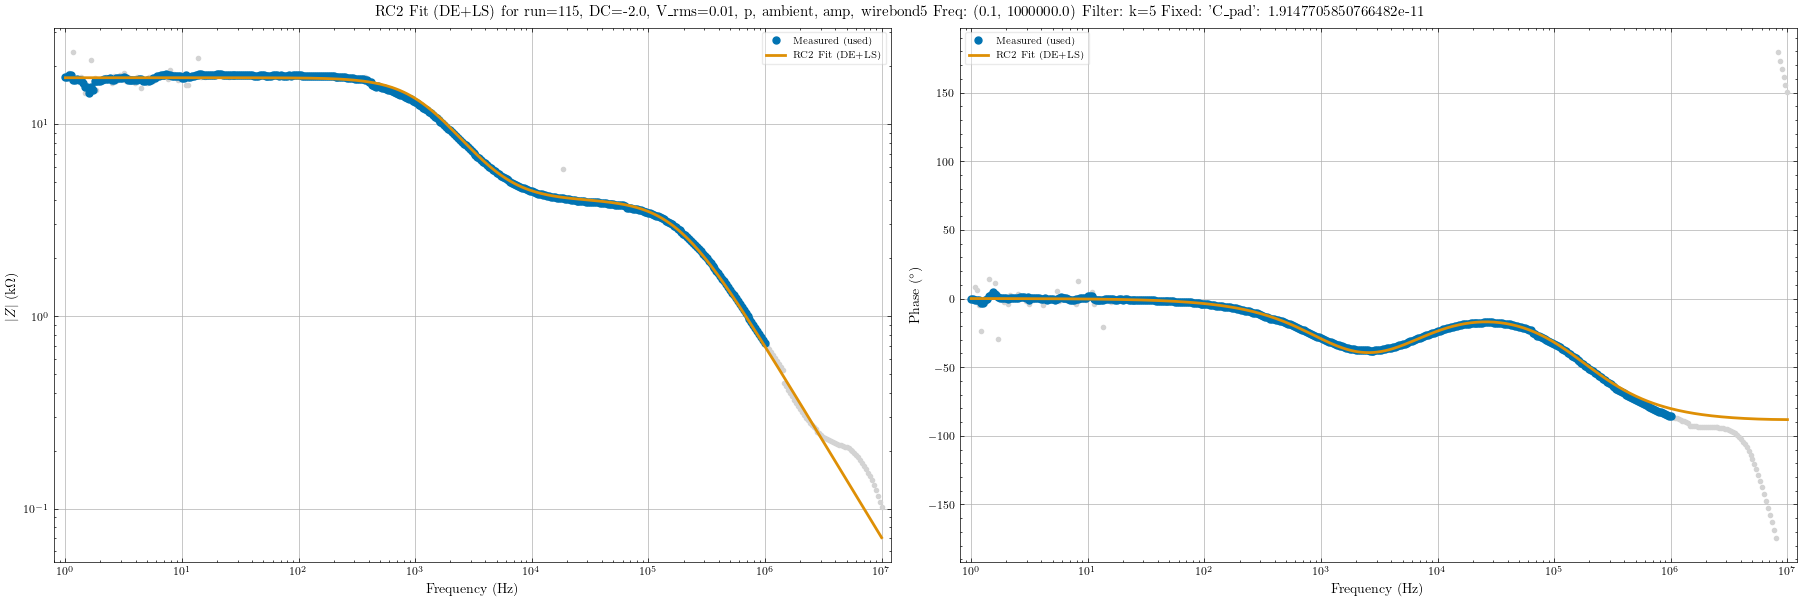


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13446.00238323852), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3933.3696956375848), 'C_mem2': np.float64(2.3061047413857994e-10), 'R_series': np.float64(1.0000023367747417)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.2727e-01
  DE Best:)
name R_mem1: 1.33e+04
name C_mem1: 1.00e-08
name R_mem2: 3.99e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.7156e-01
  Final Fitted Parameters:
    R_mem1: 1.3339e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

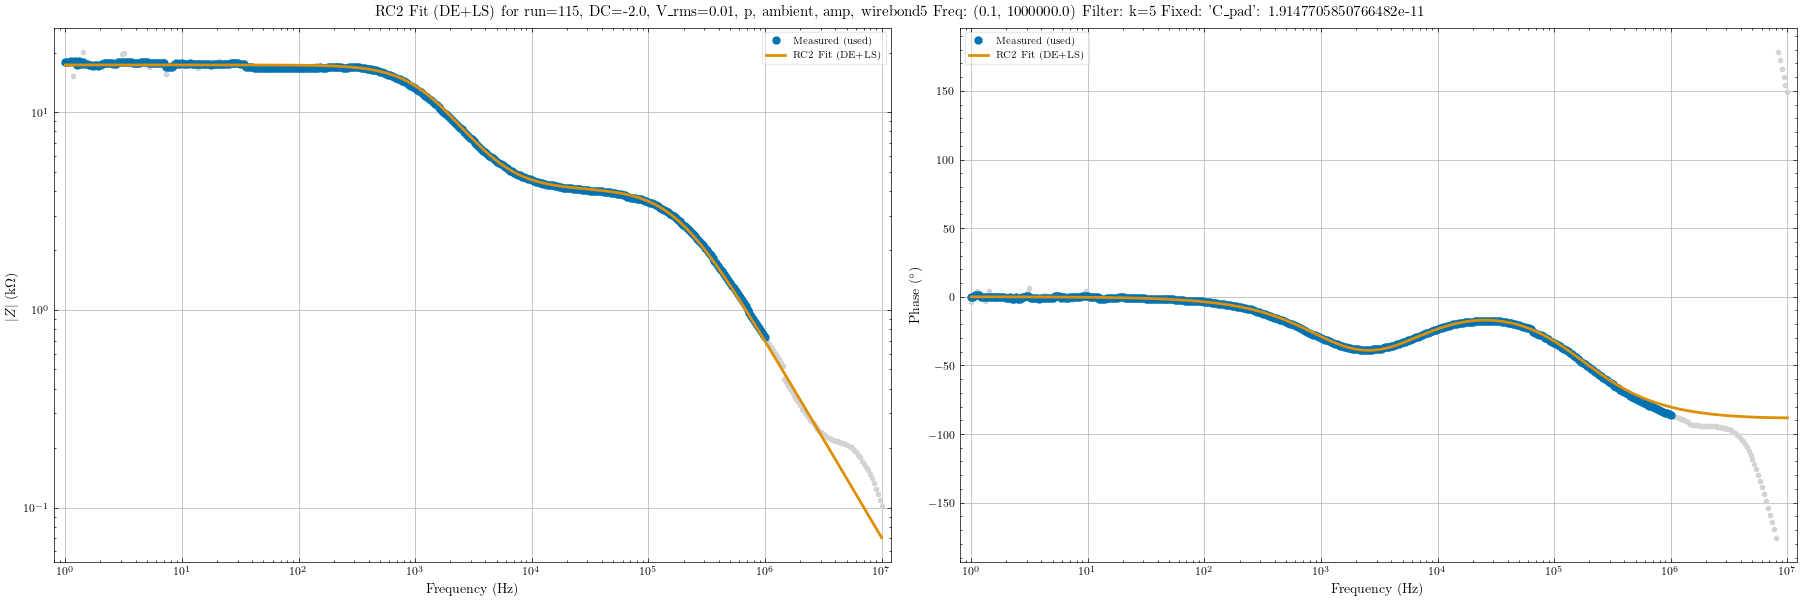


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13339.003157861473), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3994.3861004190985), 'C_mem2': np.float64(2.311023405958295e-10), 'R_series': np.float64(1.0000465160237582)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.7998e-01
  DE Best:)
name R_mem1: 1.25e+04
name C_mem1: 1.00e-08
name R_mem2: 3.90e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.4837e-01
  Final Fitted Parameters:
    R_mem1: 1.2543e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

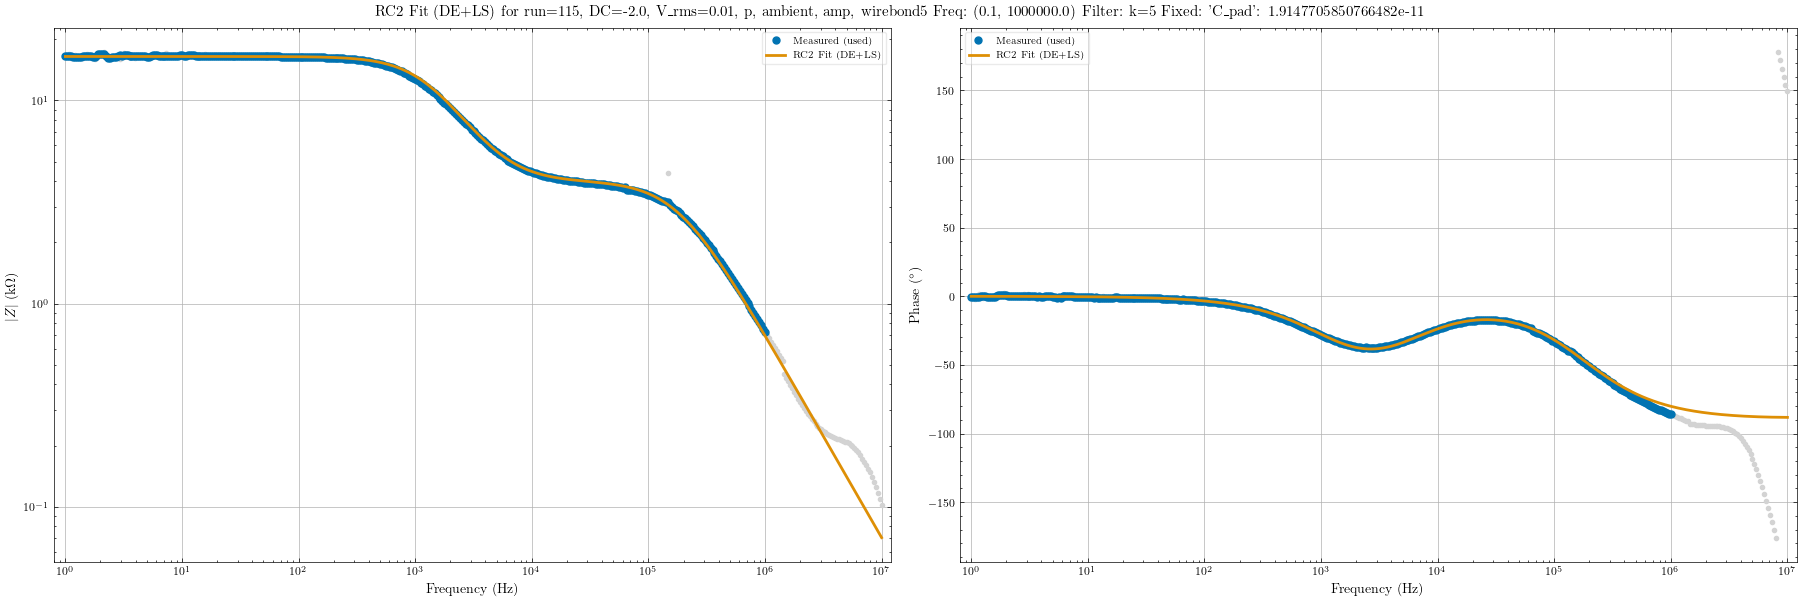


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12542.709071160003), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3899.01018506694), 'C_mem2': np.float64(2.3103493030581453e-10), 'R_series': np.float64(1.000062597683609)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.0462e-01
  DE Best:)
name R_mem1: 1.38e+04
name C_mem1: 1.00e-08
name R_mem2: 3.88e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.1284e-01
  Final Fitted Parameters:
    R_mem1: 1.3786e+04
    C_mem1: 9.9000e-09
    R_mem2: 3.8

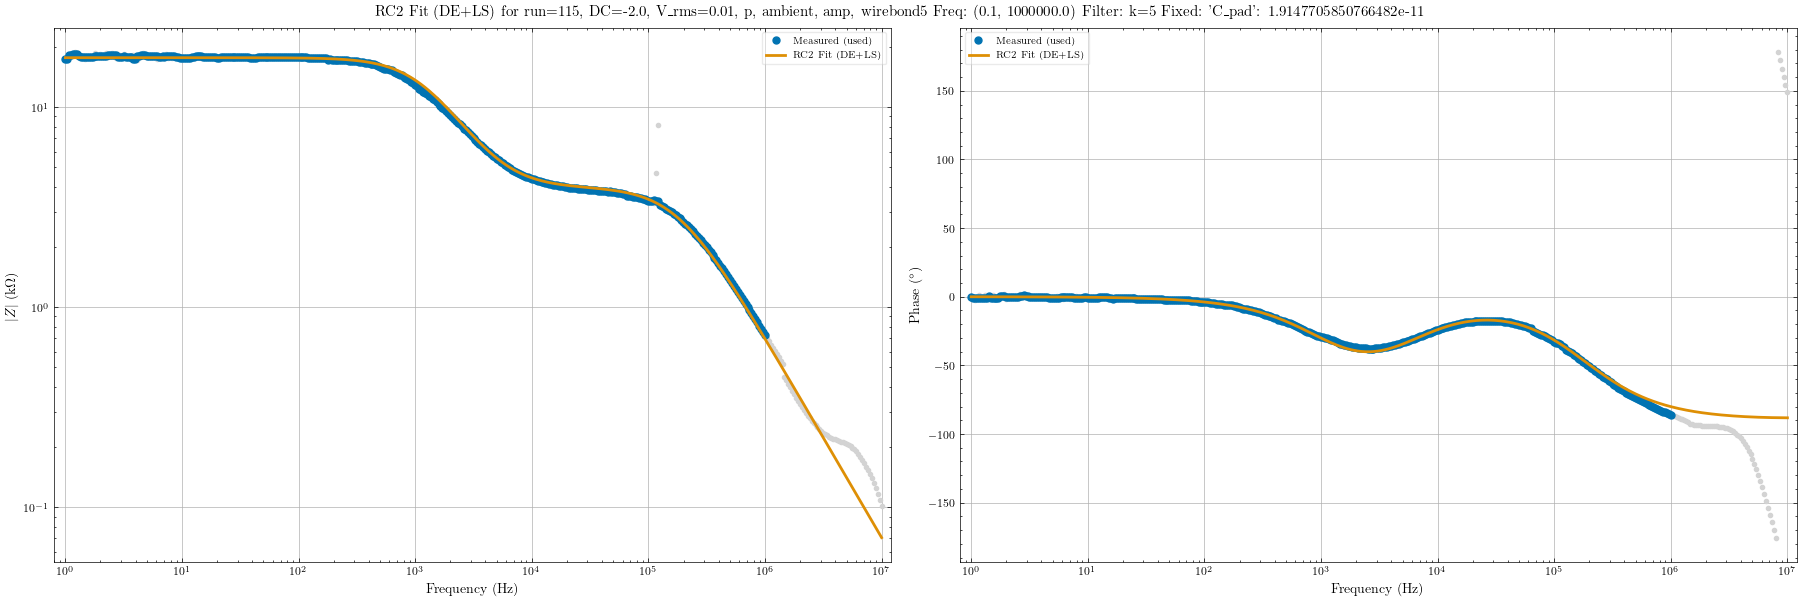


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13785.500278295134), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3876.1196633055497), 'C_mem2': np.float64(2.3071601056800923e-10), 'R_series': np.float64(1.0000243171853072)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.5792e-01
  DE Best:)
name R_mem1: 1.27e+04
name C_mem1: 1.00e-08
name R_mem2: 4.00e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.8765e-01
  Final Fitted Parameters:
    R_mem1: 1.2654e+04
    C_mem1: 9.9000e-09
    R_mem2: 

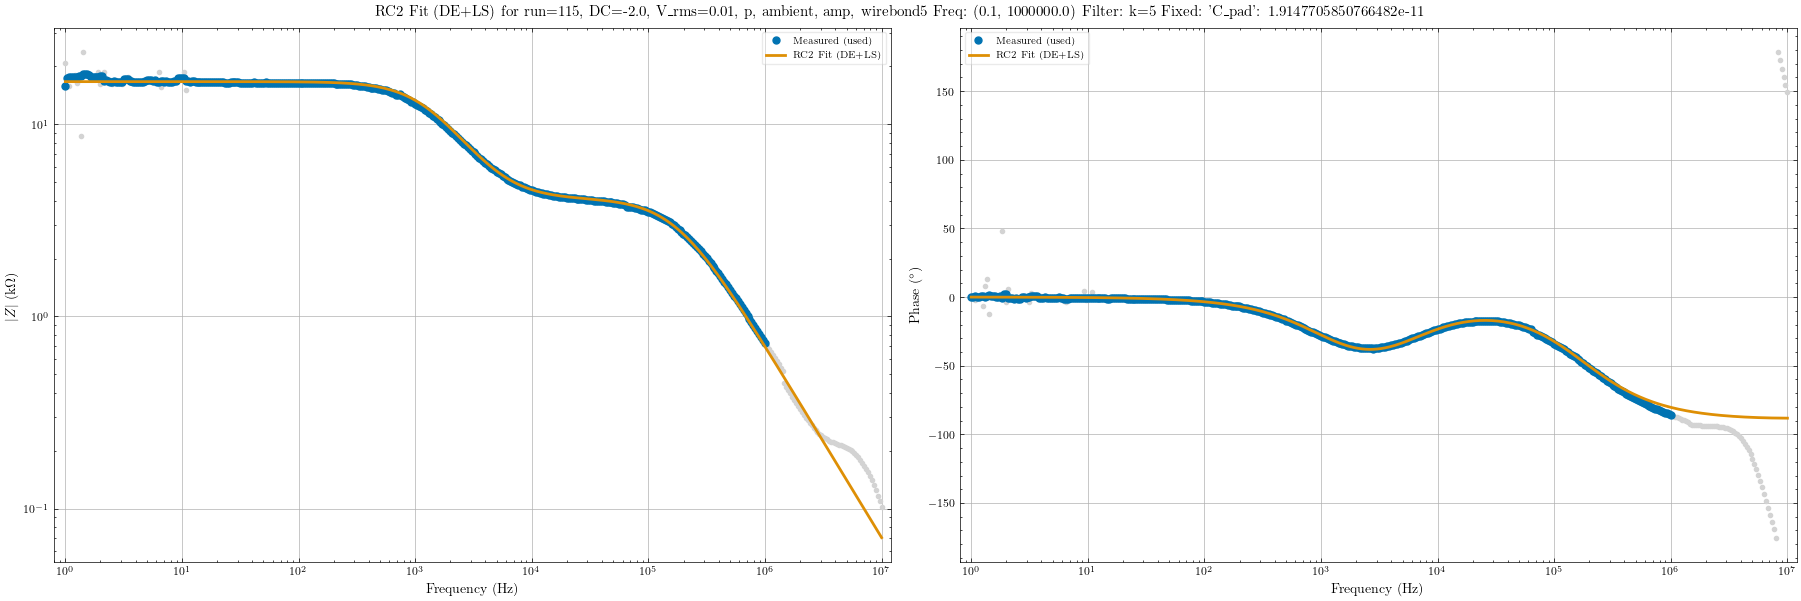


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12654.230270103493), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3999.8906844699277), 'C_mem2': np.float64(2.3078565442028703e-10), 'R_series': np.float64(1.0001089374354706)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.9857e-01
  DE Best:)
name R_mem1: 1.26e+04
name C_mem1: 1.00e-08
name R_mem2: 3.91e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.0844e-01
  Final Fitted Parameters:
    R_mem1: 1.2619e+04
    C_mem1: 9.9000e-09
    R_mem2: 

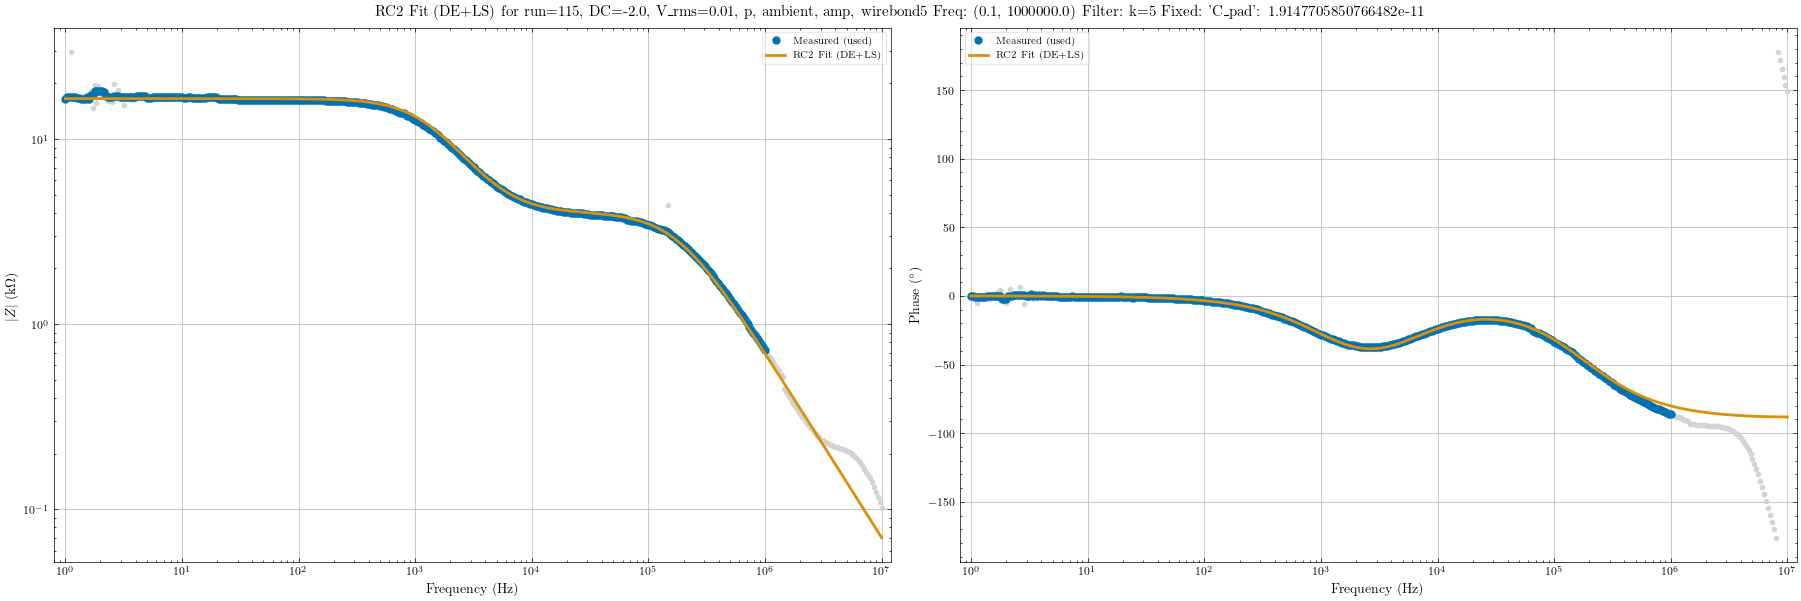


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12619.32861675293), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3907.9299031479486), 'C_mem2': np.float64(2.312557577496442e-10), 'R_series': np.float64(1.0001853776202552)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.0508e-01
  DE Best:)
name R_mem1: 1.25e+04
name C_mem1: 1.00e-08
name R_mem2: 3.92e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.6075e-01
  Final Fitted Parameters:
    R_mem1: 1.2473e+04
    C_mem1: 9.9000e-09
    R_mem2: 3.

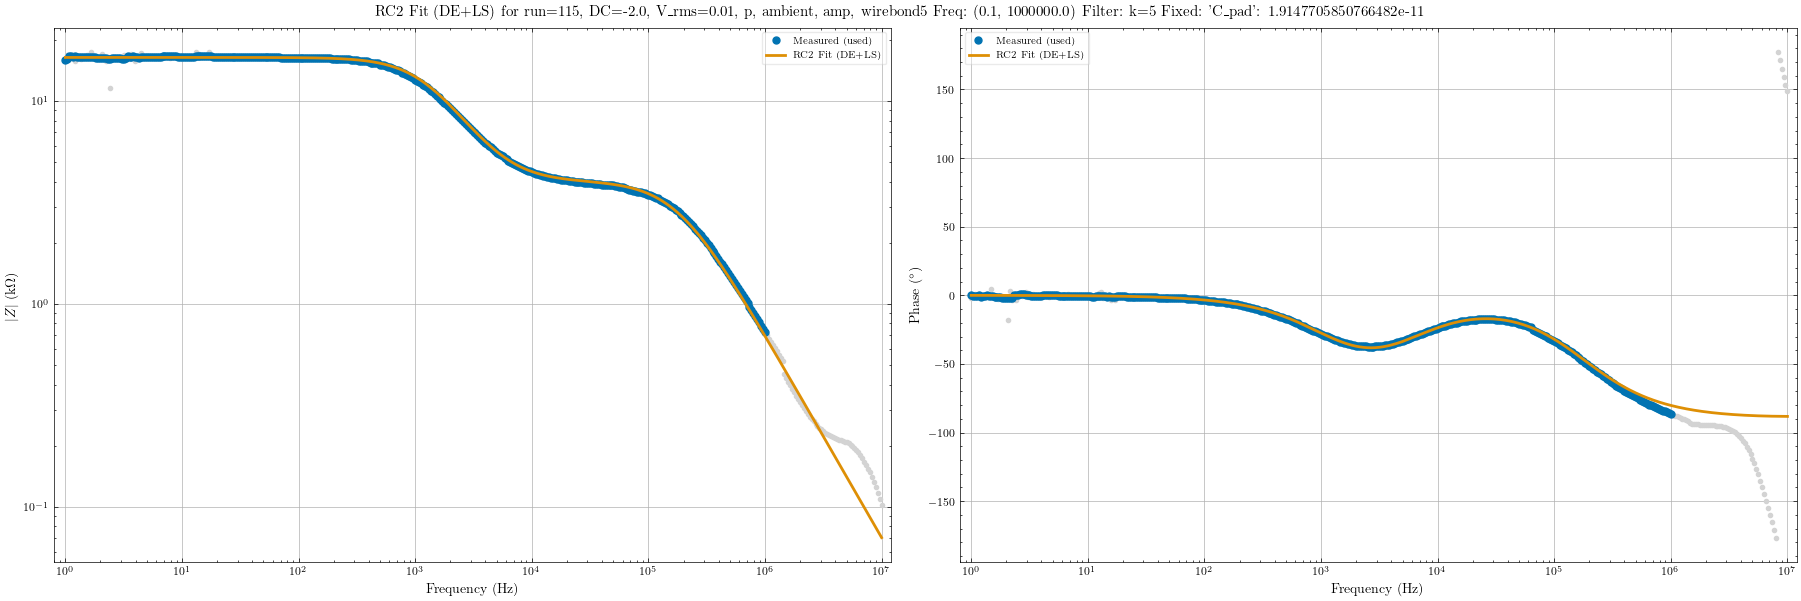


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12473.416889046843), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3920.7973935495356), 'C_mem2': np.float64(2.3149613352446295e-10), 'R_series': np.float64(1.0000193216783373)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.6517e-01
  DE Best:)
name R_mem1: 1.27e+04
name C_mem1: 1.00e-08
name R_mem2: 3.92e+03
name C_mem2: 2.31e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.9222e-01
  Final Fitted Parameters:
    R_mem1: 1.2713e+04
    C_mem1: 9.9000e-09
    R_mem2: 

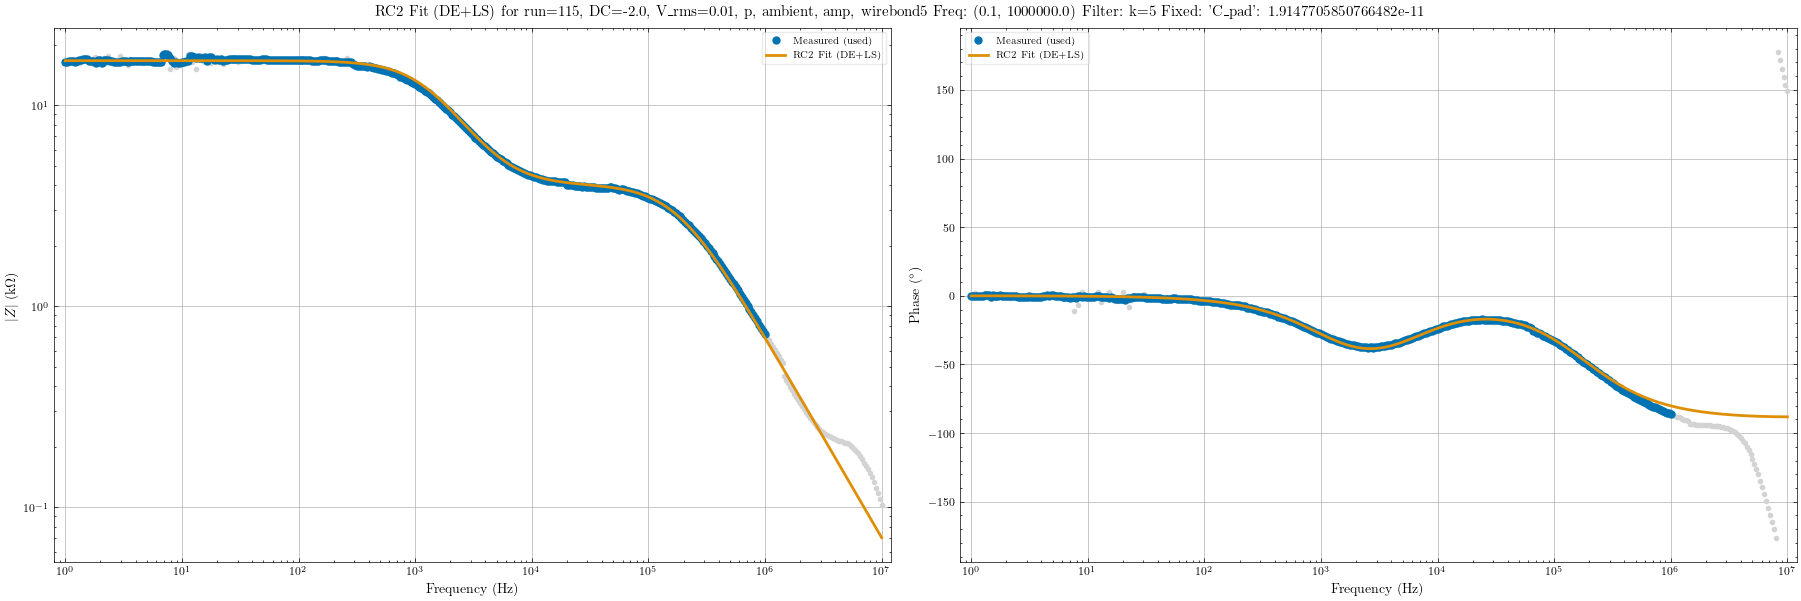


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12712.773901327164), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3922.7441654867544), 'C_mem2': np.float64(2.311012747182554e-10), 'R_series': np.float64(1.0000211866245081)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.0505e-01
  DE Best:)
name R_mem1: 1.28e+04
name C_mem1: 1.00e-08
name R_mem2: 3.83e+03
name C_mem2: 2.30e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.1193e-01
  Final Fitted Parameters:
    R_mem1: 1.2836e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

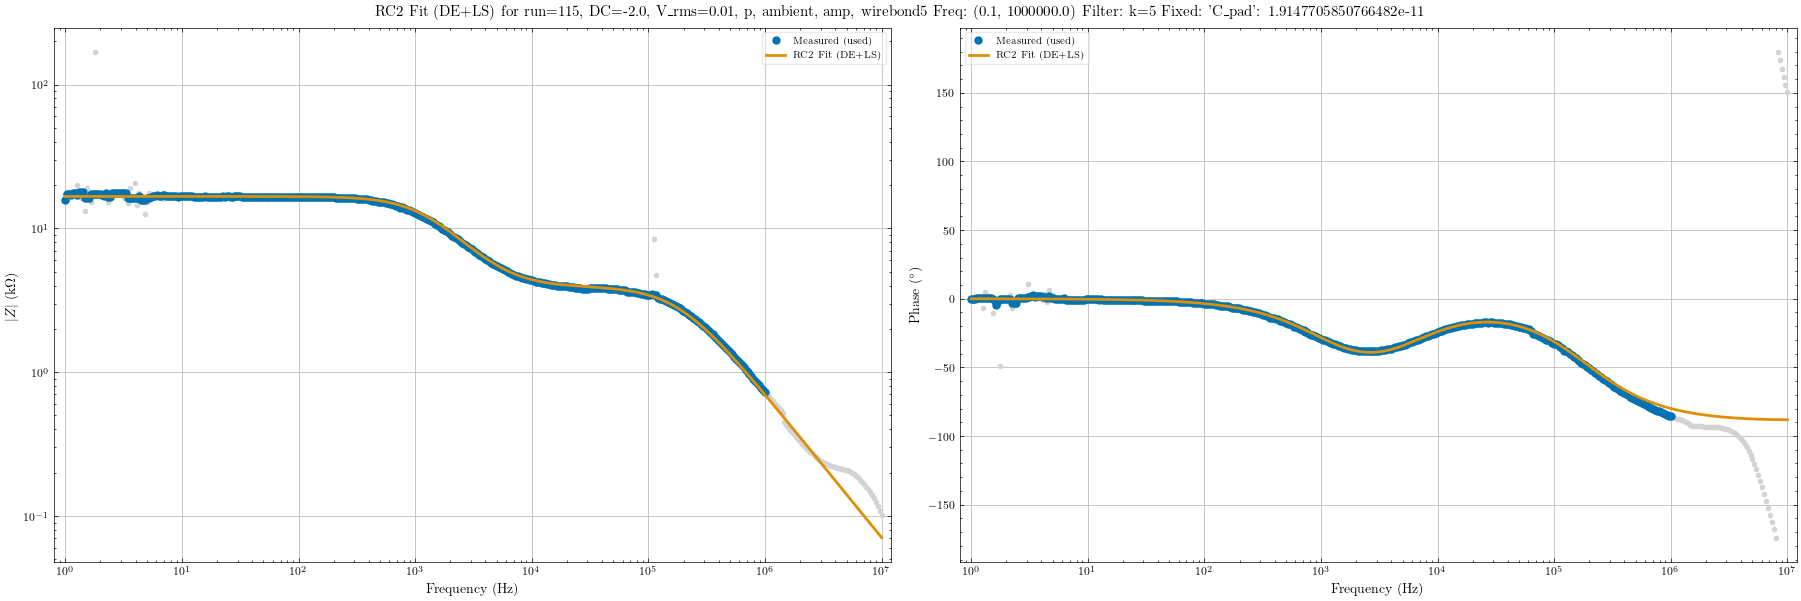


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12836.046755501418), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3831.594957926829), 'C_mem2': np.float64(2.3026822356585708e-10), 'R_series': np.float64(1.0000064421947172)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.6176e-01
  DE Best:)
name R_mem1: 1.23e+04
name C_mem1: 1.00e-08
name R_mem2: 3.68e+03
name C_mem2: 2.30e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.3937e-01
  Final Fitted Parameters:
    R_mem1: 1.2255e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

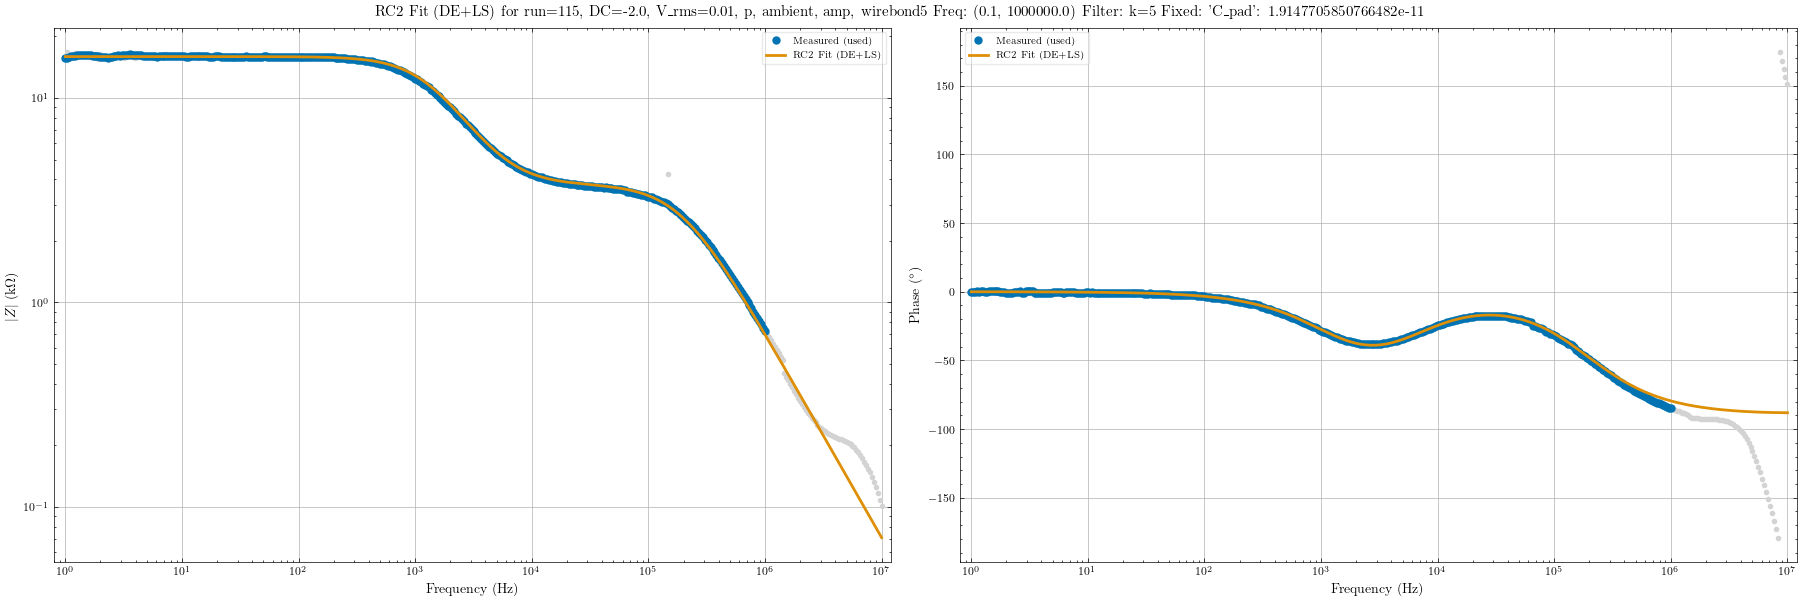


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12254.959384138754), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3680.0272421596037), 'C_mem2': np.float64(2.300894535845917e-10), 'R_series': np.float64(1.000058110739701)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.5300e-01
  DE Best:)
name R_mem1: 1.34e+04
name C_mem1: 1.00e-08
name R_mem2: 3.82e+03
name C_mem2: 2.27e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.3433e-01
  Final Fitted Parameters:
    R_mem1: 1.3421e+04
    C_mem1: 9.9000e-09
    R_mem2: 3.

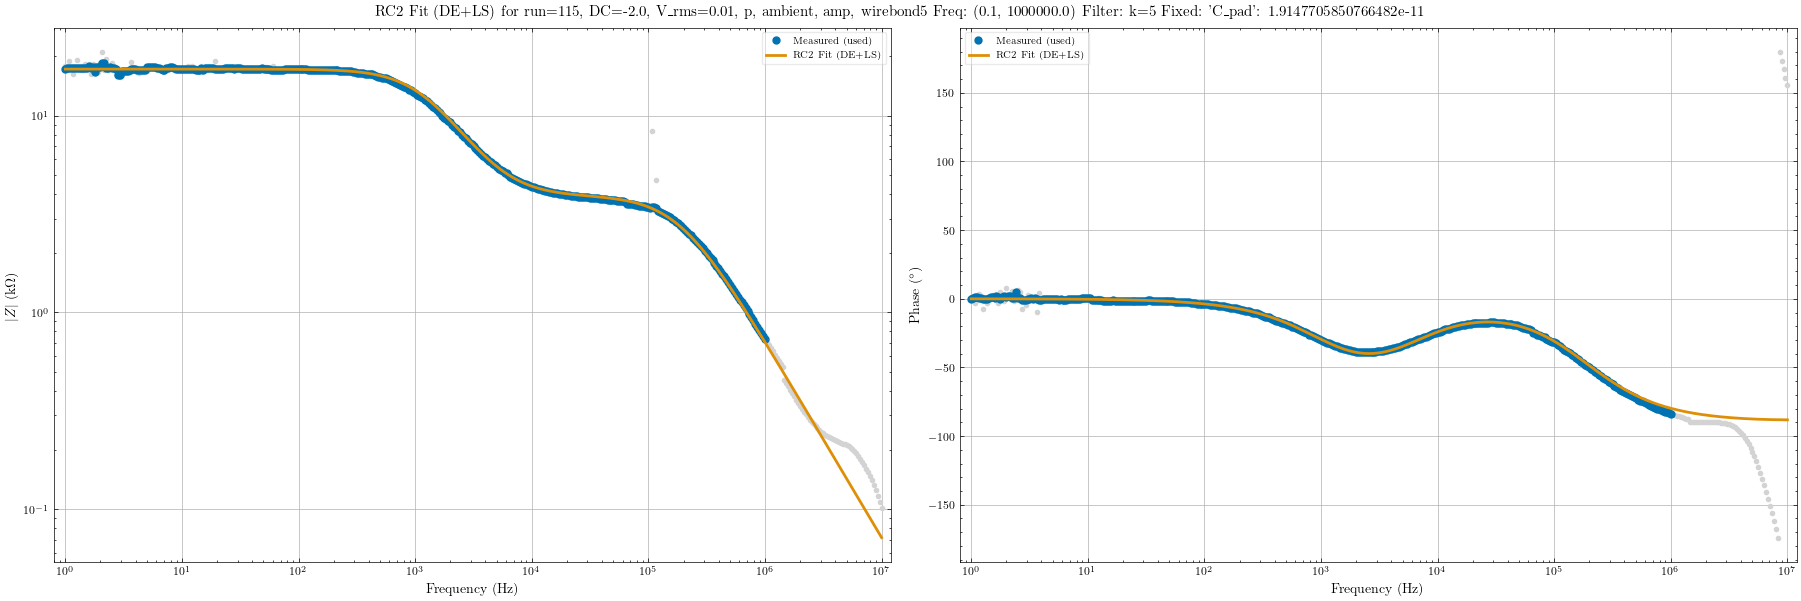


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13420.807804300915), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3817.663333662303), 'C_mem2': np.float64(2.2719201815993897e-10), 'R_series': np.float64(1.0000347580134985)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.5644e-01
  DE Best:)
name R_mem1: 1.24e+04
name C_mem1: 1.00e-08
name R_mem2: 3.79e+03
name C_mem2: 2.28e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.3662e-01
  Final Fitted Parameters:
    R_mem1: 1.2428e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

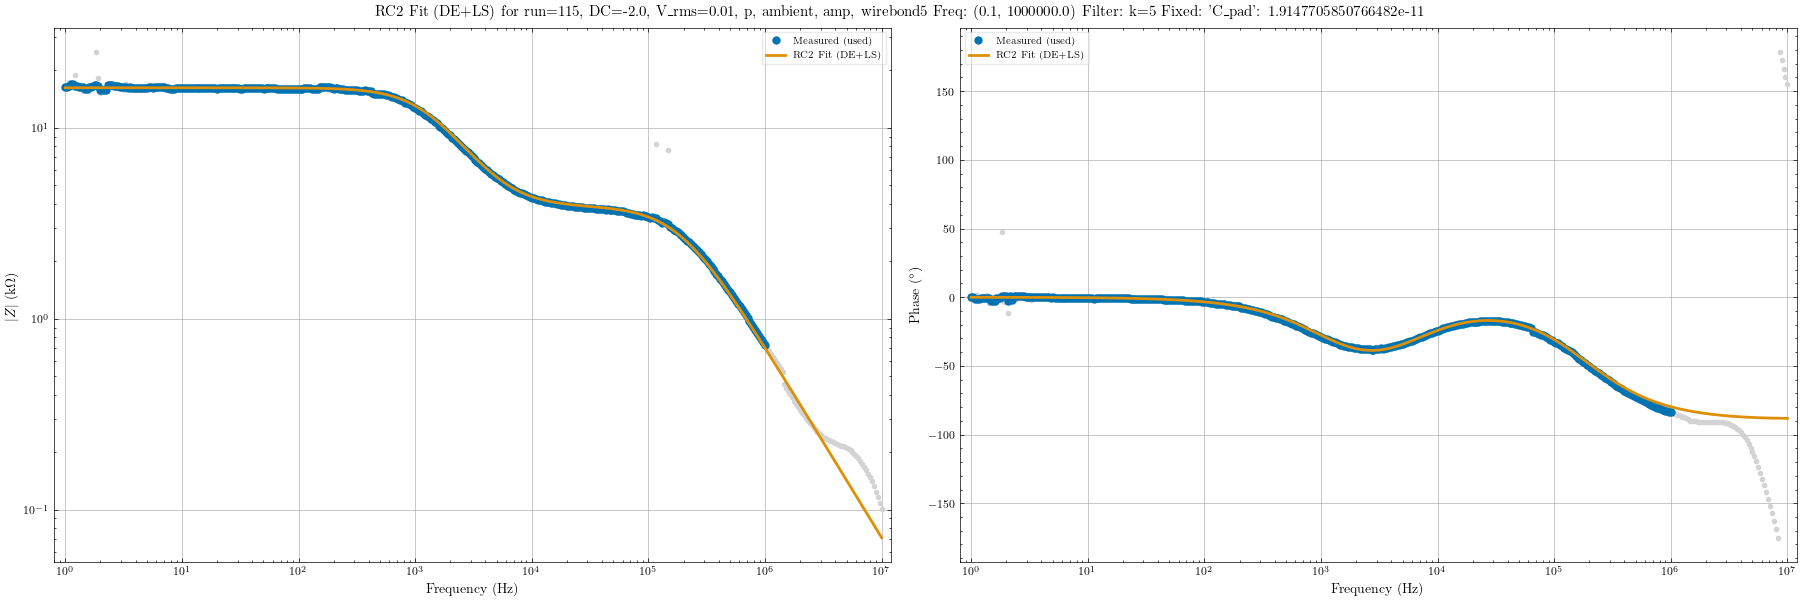


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12428.455586265656), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3787.9597069771476), 'C_mem2': np.float64(2.279281246043309e-10), 'R_series': np.float64(1.0000107075611595)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.0546e-01
  DE Best:)
name R_mem1: 1.25e+04
name C_mem1: 1.00e-08
name R_mem2: 3.71e+03
name C_mem2: 2.28e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.6021e-01
  Final Fitted Parameters:
    R_mem1: 1.2531e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

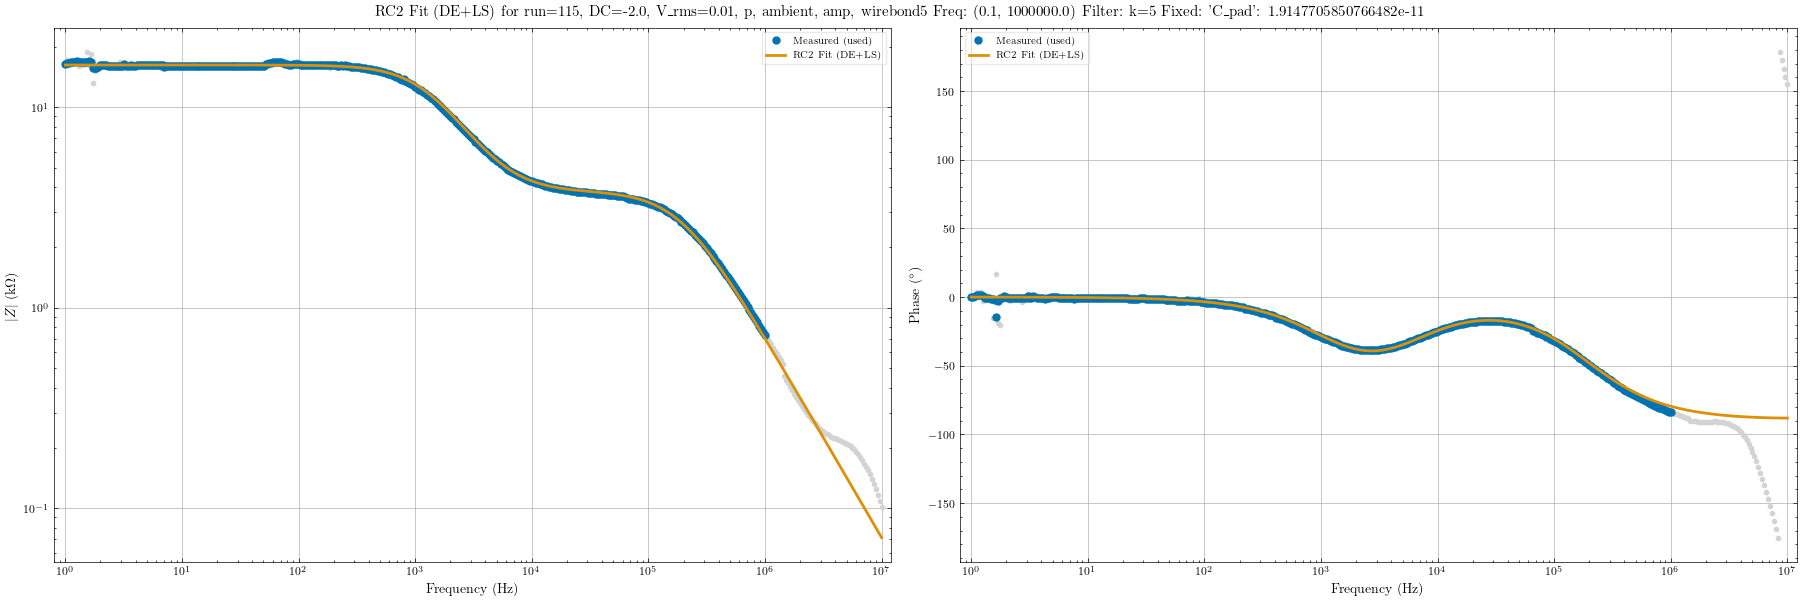


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12530.720430603717), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3711.1023657021938), 'C_mem2': np.float64(2.2827935524422697e-10), 'R_series': np.float64(1.000006822478099)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 2.5025e-01
  DE Best:)
name R_mem1: 1.28e+04
name C_mem1: 1.00e-08
name R_mem2: 3.78e+03
name C_mem2: 2.28e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 1.3350e-01
  Final Fitted Parameters:
    R_mem1: 1.2821e+04
    C_mem1: 9.9000e-09
    R_mem2: 3

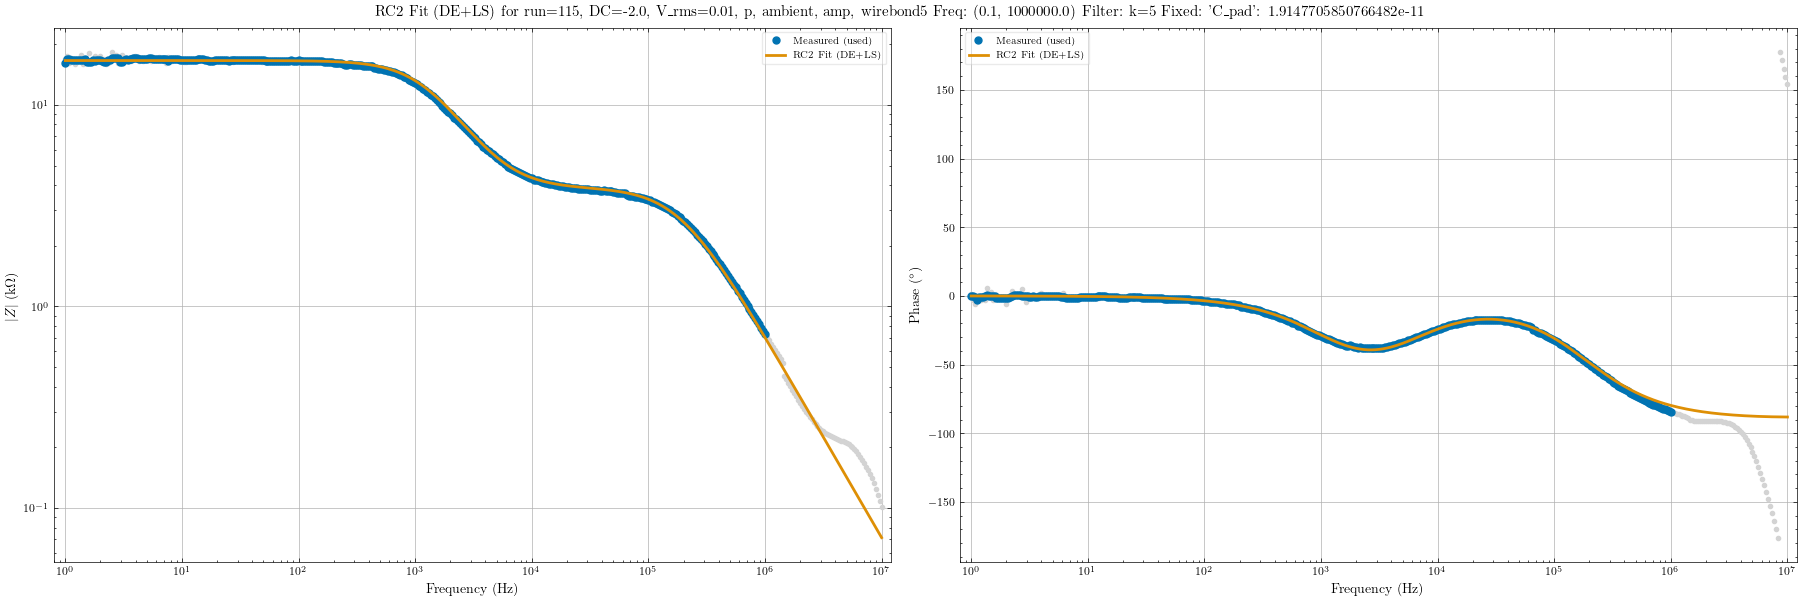


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(12821.392886729911), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3781.7738919519), 'C_mem2': np.float64(2.284943257837976e-10), 'R_series': np.float64(1.0000540271630598)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---

--- Starting Fit for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.4066e-01
  DE Best:)
name R_mem1: 1.31e+04
name C_mem1: 1.00e-08
name R_mem2: 3.85e+03
name C_mem2: 2.29e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.2973e-01
  Final Fitted Parameters:
    R_mem1: 1.3145e+04
    C_mem1: 9.9000e-09
    R_mem2: 3.84

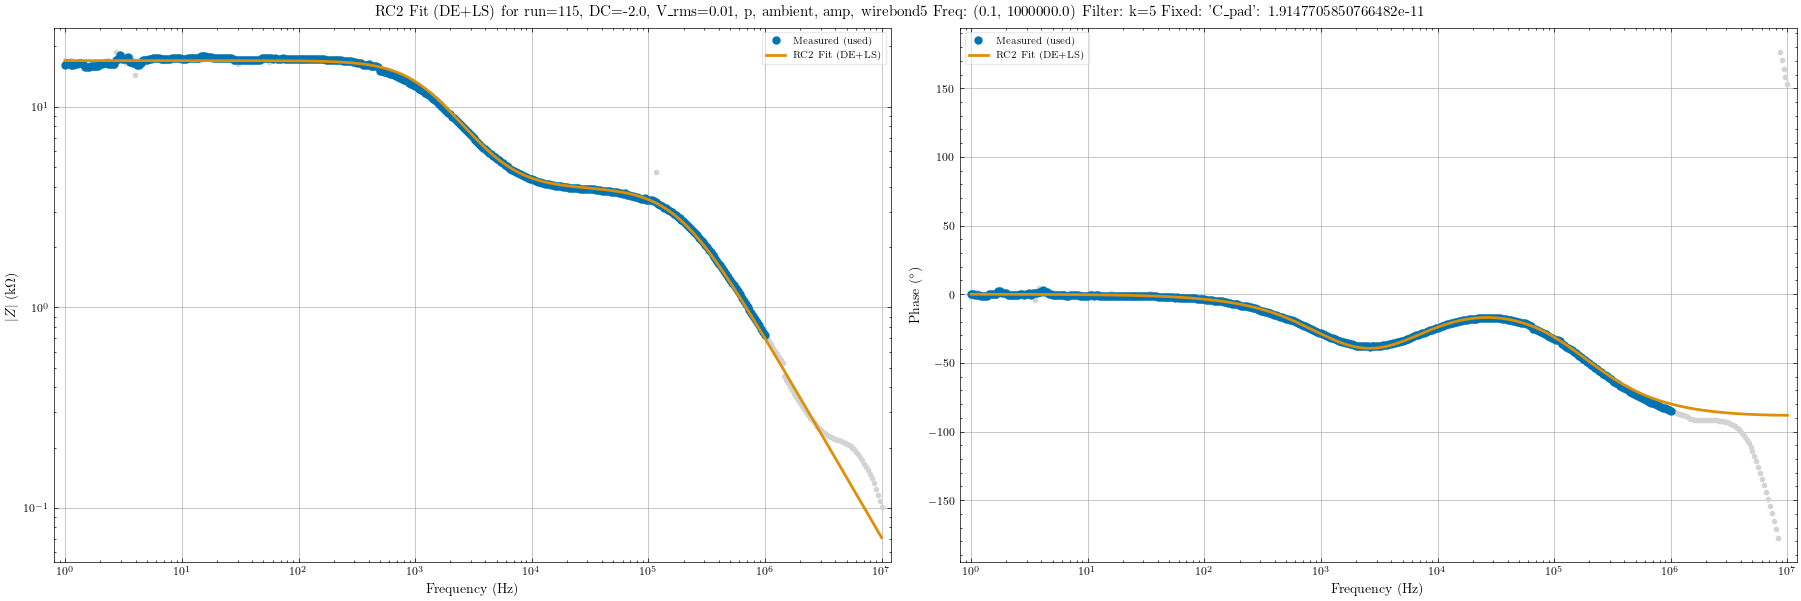


Final Fitted Parameters Dictionary:
{'C_pad': 1.9147705850766482e-11, 'R_mem1': np.float64(13145.096861765604), 'C_mem1': np.float64(9.900000000000001e-09), 'R_mem2': np.float64(3846.72234872621), 'C_mem2': np.float64(2.2892952685373994e-10), 'R_series': np.float64(1.0000039566502892)}
--- Fit finished for: run=115, DC=-2.0, V_rms=0.01, p, ambient, amp, wirebond5 ---


In [43]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC2', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': True, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# --- Select Data ---
# Select data 
d113  = [d_vac_set, d_amb_set]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)

for dat in d113:
    # --- Run Fit ---
    fig, ax = fit_impedance_data(dat, **fit_settings)




### SET - vac v amb

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


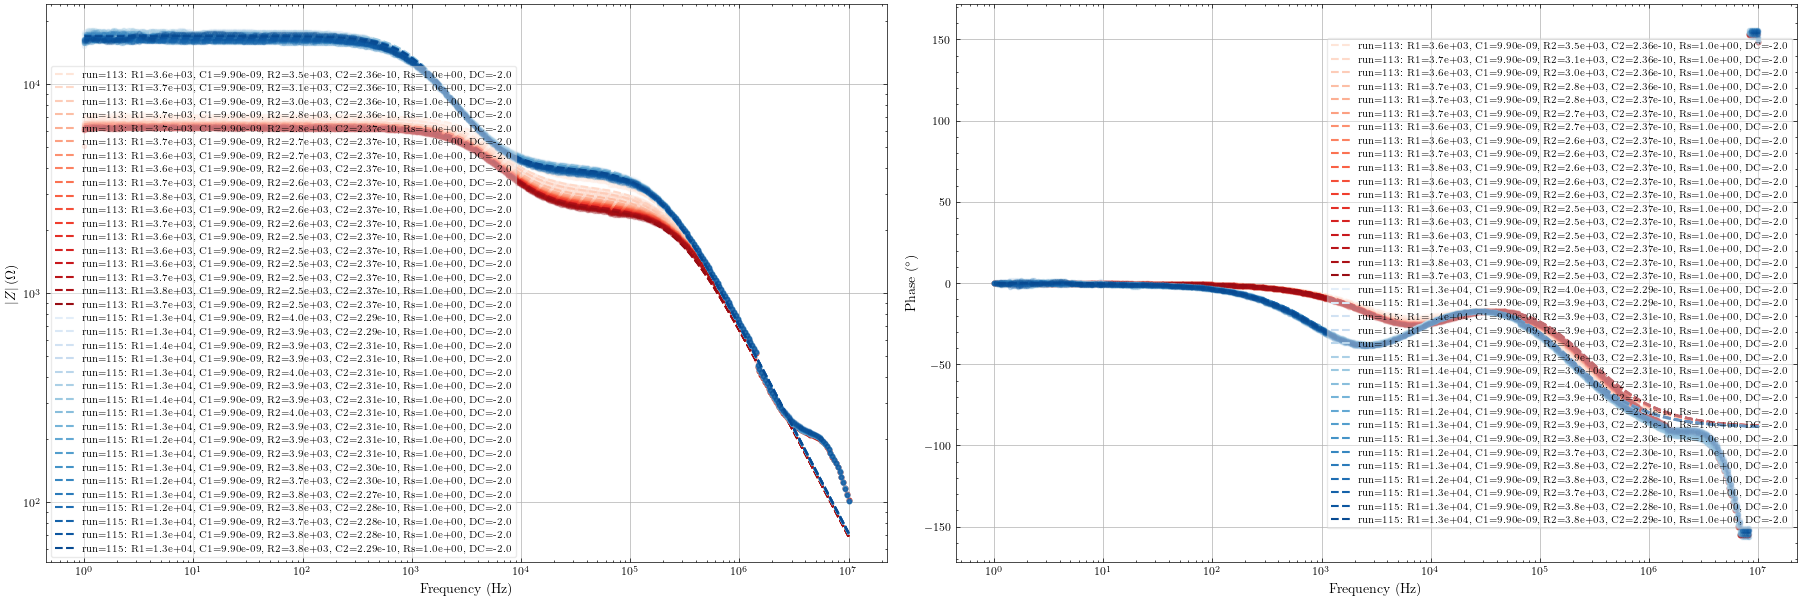

In [46]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacwithkey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


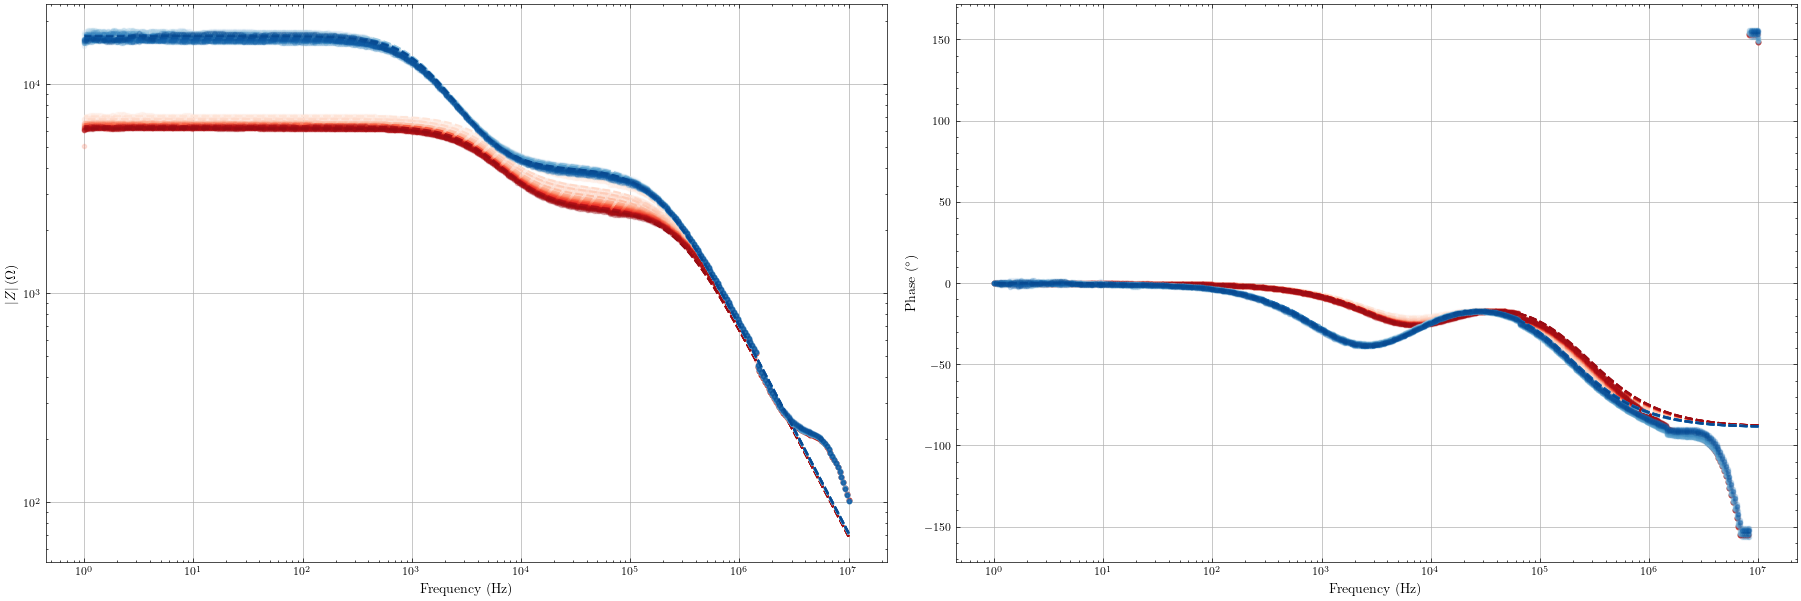

In [49]:

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacnokey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

### Ambient

NameError: name 'solatron' is not defined

In [48]:
25e-9/((20e-6)**2 *2.46e-4)
print( 9e-9 *25e-9/((20e-6)**2 *epsilon_0))

2541.1703998672797


# Exporting

### Exporting All Figures as Individual Files

In [23]:
if export_data:
    for fig_obj, fig_name, fig_title, notes in fig_list:
        save_path = Path(output_IS_solatron) / Path(f"{fig_name}_{powerpoint_string}.{fig_format}")
        fig_obj.savefig(save_path, dpi=600, bbox_inches='tight', transparent=plot_transparency)

### Exporting to Powerpoint

In [ ]:
if export_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()
    [prs.slide_width, prs.slide_height] = [Inches(13.333), Inches(7.5)]
   
    # define the path to the output directory
    path_out = output_IS_solatron

    # Add each figure to the PowerPoint presentation if it exists
    for fig, fig_name, title, notes in fig_list:
        add_slide(fig, title, notes, prs, path_out = path_out, layout = 'vertical')

    # Save the PowerPoint presentation
    prs.save(Path(path_out) / Path(f'{powerpoint_string}.pptx'))

In [ ]:
# Select data 
# ---------------------------------------- Plotting the Fitting ------------------------------
# Section off the Vacuum Data
d_vac_set_test = solatron[113][0::4]
d_vac_reset = solatron[113][1::4]
d_vac_reset_test = solatron[113][2::4]
d_vac_set = solatron[113][3::4]

# Section off the Ambient Data
d_amb_set_test = solatron[115][0::4]
d_amb_reset = solatron[115][1::4]
d_amb_reset_test = solatron[115][2::4]
d_amb_set = solatron[115][3::4]
    
d = [d_vac_set_test, d_vac_reset, d_vac_reset_test, d_vac_set, d_amb_set_test, d_amb_reset, d_amb_reset_test, d_amb_set]
# extract a single DC level from the data
#d = extract_single_dc(d, DC_val=0)

# Labels
plot_labels = ['wb5, formed, vacuum', 'wb5, formed, ambient-failed', 'wb5, formed, ambient'] # label for the legend
plot_filename = 'wb5_liveswitching_ambvsvac' # name for exported figure
plot_title = 'Switching Device with DC Offset in Vacuum and Ambient' # title for powerpoint

# Notes
notes = ['All runs use a loop [0, 2.5V, 0, -2V] to measure state then switch ON/OFF then measure state'
        'Vacuum was left at 9e-7 for 3 days before starting the run',
         'First ambient run was started after 7 hours at ambient but crashed part way through',
         'Second ambient run was started 2 days after the vacuum and completed successfully',
         ] # notes for the powerpoint in text box

# if export true, update the plot string
d = update_plot_string(d, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 9, force_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 